# pre

## import & setting

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import seaborn as sns
import palettable
import pandas as pd
import scipy
import scipy.io as sio
import pickle
import sys
sys.path.append('/home/yzy/bioSIMS/code/analysis')
from utils_220 import *
sc.set_figure_params(dpi=500, color_map='viridis',transparent=True,dpi_save=500)
sc.settings.verbosity = 2
%matplotlib inline


Using TensorFlow backend.
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.bicluster module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


## functions

In [23]:
def get_fibro_stat(a_use,start_dist,k_split,end_dist,c_hep_normal='5',c_hep_87='6'):
    # a_use = a_concat_6
#     c_hep_normal='4'
#     c_hep_87='6'
    # c_hep_87_ = '5'
    # c_hep_87='3'
    cur_exp_name='final_cls'

    hepa_dist_pd_dict = {
        'dist':[],
        'dist_lim':[],
        'hepa_type':[]
    }


    a_hep_normal = a_use[a_use.obs[cur_exp_name]==c_hep_normal]
    a_hep_normal = a_hep_normal[a_hep_normal.obs['fibro_dist_mum']>0]
    # a_hep_87 = a[a.obs[cur_exp_name]==c_hep_87]
    a_hep_87 = a_use[a_use.obs[cur_exp_name].isin([c_hep_87])]
    a_hep_87 = a_hep_87[a_hep_87.obs['fibro_dist_mum']>0]


    a_hep_all = a_use[a_use.obs[cur_exp_name].isin([c_hep_87,c_hep_normal])]
    a_hep_all = a_hep_all[a_hep_all.obs['fibro_dist_mum']>0]

    thre_list = []
    count_normal_list = []
    count_normal_standard_list = []
    count_87_list = []
    count_87_standard_list = []
    count_ratio_list = []
    count_ratio_standard_list =[]
    dist_pvalue_list = []
    dist_pvalue_list2 = []
    dist_87_list = []
    dist_normal_list = []
    dist_all_list = []
    dist_ratio_list = []

    a_hep_87_num = a_hep_87.shape[0]
    a_hep_normal_num = a_hep_normal.shape[0]
    prev_i = 0
    # start_dist = 10
    # k_split = 8
    thre_range = range(start_dist,end_dist,k_split)
    
#     if k_split>=0:
        
#         thre_range = range(start_dist,end_dist,100)
#     else:
#         thre_range = range(start_dist,end_dist,1)
    # thre_range = [100,200,250,300,350,400,450]
    # thre_range = [100,200,300,400,500]

    for i in thre_range:
        if i%100==0:
            print(i)
        cur_a_all = a_hep_all[a_hep_all.obs['fibro_dist_mum']<i]
        cur_a_87 = a_hep_87[a_hep_87.obs['fibro_dist_mum']<i]
        cur_a_normal = a_hep_normal[a_hep_normal.obs['fibro_dist_mum']<i]



        cur_dist_87 = cur_a_87.obs['fibro_dist_mum']
        cur_dist_all = cur_a_all.obs['fibro_dist_mum']
        cur_dist_normal = cur_a_normal.obs['fibro_dist_mum']

        dist_87_list.append(np.mean(cur_dist_87))
        dist_normal_list.append(np.mean(cur_dist_normal))
        dist_all_list.append(np.mean(cur_dist_all))
        dist_ratio_list.append(np.mean(np.mean(cur_dist_normal)/np.mean(cur_dist_87)))



    #     cur_dist_87_resample = np.random.choice(cur_dist_87, a_hep_87_num)
    #     cur_dist_normal_resample = np.random.choice(cur_dist_normal, a_hep_normal_num)



        _,pvalue = scipy.stats.mannwhitneyu(cur_dist_87,cur_dist_normal,alternative='less')
        _,pvalue2 = scipy.stats.ttest_ind(cur_dist_87,cur_dist_normal)

        dist_pvalue_list.append(pvalue)
#         dist_pvalue_list2.append(pvalue2)

        count_normal = np.sum(a_hep_normal.obs['fibro_dist_mum']<i)
        count_normal_standard = count_normal/a_hep_normal.shape[0]
        count_87 = np.sum(a_hep_87.obs['fibro_dist_mum']<i)
        count_87_standard = count_87/a_hep_87.shape[0]

        thre_list.append(i)
        count_normal_list.append(count_normal)
        count_87_list.append(count_87)
        count_ratio_list.append(count_87/count_normal)

        count_normal_standard_list.append(count_normal_standard)
        count_87_standard_list.append(count_87_standard)
        count_ratio_standard_list.append(count_87_standard/count_normal_standard)


        cur_dist_list = list(cur_dist_87)
        cur_dist_list.extend(list(cur_dist_normal))
        cur_hepatype_list = ['69+']*cur_dist_87.shape[0]
        cur_hepatype_list.extend(['69-']*cur_dist_normal.shape[0])
        cur_distlim_list = [i]*len(cur_hepatype_list)
        hepa_dist_pd_dict['dist'].extend(cur_dist_list)
        hepa_dist_pd_dict['dist_lim'].extend(cur_distlim_list)
        hepa_dist_pd_dict['hepa_type'].extend(cur_hepatype_list)
        prev_i = i
    return thre_list,dist_ratio_list,dist_pvalue_list,hepa_dist_pd_dict,count_ratio_standard_list
    # deletes



In [3]:
def plot_count_ratio(count_ratio_standard_list,thre_list,save):
    sns.set_style('white')
#     save_tmp = 'figures/fibro_dist_line_{0}.png'

    t=thre_list
    data1 = count_ratio_standard_list
    # data2 = -np.log10(dist_pvalue_list2)
    fig, ax1 = plt.subplots(1,1,figsize=(6/1.5,5/1.5))

    color = 'k'
    ax1.set_xlabel('distance to Fib border')
    ax1.set_ylabel('scaled cell count ratio', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    # color = 'tab:blue'
    # ax2.set_ylabel('P value (-log10)', color=color)  # we already handled the x-label with ax1
    # ax2.plot(t, data2, color=color)
    # ax2.tick_params(axis='y', labelcolor=color)
    ax1.spines["bottom"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1.spines["top"].set_color("black")
    ax1.spines['right'].set_color("black")
    # ax.spines["left"].set_facecolor("red")
    # ax1.spines["left"].set_linewidth(2)
    # ax1.spines["bottom"].set_linewidth(2)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save:
        
        plt.savefig(save,transparent=True,format='png',bbox_inches='tight',dpi=500)
    else:
        plt.show()
        
    # plt.savefig(transparent=True,format='png',bbox_inches='tight',dpi=500)


In [15]:
def plot_dist_box(hepa_dist_pd_dict,save):
    hepa_dist_pd_df = pd.DataFrame(hepa_dist_pd_dict)

    import seaborn as sns
    sns.set(style="ticks", palette="pastel")

#     save = 'figures/fibro_dist_box3.png'
    # Load the example tips dataset
    # tips = sns.load_dataset("tips")

    # Draw a nested boxplot to show bills by day and time
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    g = sns.boxplot(x="dist_lim", y="dist",
                hue="hepa_type", palette=["#FF005C", "#68FF00"],saturation=1,fliersize=1,linewidth=2,
                data=hepa_dist_pd_df,ax=ax)
    sns.despine(offset=10, trim=True)
    ax.get_legend().remove()

    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
    #     box.set_facecolor('white')

        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('black')

    # plt.savefig(save,transparent=True,format='png',bbox_inches='tight',dpi=500)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    # ax.spines["left"].set_facecolor("red")
    ax.spines["left"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    # ax.tick_params(axis='y', labelcolor='red')
    # ax.tick_params(axis='x', labelcolor=color)
    # plt.setp(ax.lines, color='blue')
    if save:
#         print(111)
        plt.savefig(save,transparent=True,format='png',bbox_inches='tight',dpi=500)
    else:
        plt.show()


In [5]:
def get_adj_matters(key_matters,matter_list):
    key_matters = np.array(key_matters).astype('float')
    matter_list = np.array(matter_list).astype('float')
    adjested_key_matters = []
    for k in key_matters:
        m_diff = np.abs(matter_list-k)
        min_diff_idx = np.argmin(m_diff)
        min_diff_m = matter_list[min_diff_idx]
        adjested_key_matters.append(min_diff_m)
    adjested_key_matters = np.array(adjested_key_matters)
    return adjested_key_matters

In [6]:
def add_subcls(a_cls_sub,ec_cls,to_replace_cls):
    a_cls_sub_int = a_cls_sub.astype('int')
    a_cls_sub_int[a_cls_sub_int==int(to_replace_cls)] = -1
    a_cls_sub_int[a_cls_sub_int>int(to_replace_cls)]-=1
    a_cls_sub_int_max = a_cls_sub_int.max()
    
    ec_cls_int = ec_cls.astype('int')
    ec_cls_int -= ec_cls_int.min()
    ec_cls_int+=(a_cls_sub_int_max+1)
    a_cls_sub_int[a_cls_sub_int==-1] = ec_cls_int
    return a_cls_sub_int.astype('str')

In [7]:
def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]



In [8]:
def get_train_data(data_mat_filename,mode,norm,batch_num_list=[1]):
#     mode分为:'none','median','total'
#     norm分为:'none',standard','l1','l2'
#     batch_num_list = [3,5]
    # 5行
    # 1,2,3,4,5,6
    # batch_num = 4


    original_data = {}
    cell_related_data = {}
    data_mat = sio.loadmat(data_mat_filename)
    data_mat=data_mat['data_mat']



    num_features = data_mat.shape[1]-3
    batch_dict = {}

    label_dict = {}
    cell_dict = {}
    pos_dict = {}

    for i in range(1):

            cur_data = data_mat[data_mat[:,0]==i+1,3:num_features+3]


            batch_dict[i+1] = cur_data

            cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
            cur_batch_idx = data_mat[data_mat[:,0]==i+1,2]
            label_dict[i+1] = np.ones(shape=cur_batch_idx.shape)


            pos_dict[i+1] = cur_batch_idx
    original_data['batch_dict'] = batch_dict
    original_data['cell_dict'] = cell_dict
    original_data['label_dict'] = label_dict
    original_data['pos_dict'] = pos_dict






    top_n_var = 250
    train_x_all = None
    cell_idx_all = None
    cell_type_all = None
    cell_pos_all = None
    batch_idx_all = None
    num_cells_all = 0


    for batch_num in batch_num_list:
        train_x = batch_dict[batch_num]
        # train_x = eval('batch_dict_{norm_type}[batch_num]'.format(norm_type=norm_type))
        # train_x = batch_dict[batch_num]
        cell_idx = cell_dict[batch_num]
        cell_type = label_dict[batch_num]
        cell_pos = pos_dict[batch_num]
        # batch_FE = FE_dict[batch_num]
        cell_related_ind = (cell_idx!=0)

        num_cells = int(np.max(cell_idx))
        # num_cells = 2
        train_x = train_x[cell_related_ind,:]

        cell_idx = cell_idx[cell_related_ind]
        cell_type = cell_type[cell_related_ind]
        # cell_type = np.ones(shape=cell_idx.shape)
        cell_pos = cell_pos[cell_related_ind]





        var_li = []
        normed_var_li = []
        for i in range(train_x.shape[1]):
            cur_col = train_x[:,i]
        #     cur_col= cur_row/np.sum(cur_col)
        #     cur_entropy = entropy(cur_col)
            cur_var = np.var(cur_col)
            cur_normed_var = cur_var/np.mean(cur_col)
        #     entropy_li.append(cur_entropy)
            var_li.append(cur_var)
            normed_var_li.append(cur_normed_var)
        # entropy_li = np.array(entropy_li)
        var_li = np.array(var_li)
        normed_var_li = np.array(normed_var_li)
        sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
        sort_val = np.flip(np.sort(normed_var_li),axis=0)
        
        if train_x_all is None:
            train_x_all = train_x
        else:
            train_x_all = np.vstack([train_x_all,train_x])
        if cell_idx_all is None:
            cell_idx_all = cell_idx
        else:
            cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
        if cell_type_all is None:
            cell_type_all = cell_type
        else:
            cell_type_all = np.hstack([cell_type_all,cell_type])
        if cell_pos_all is None:
            cell_pos_all = cell_pos
        else:
            cell_pos_all = np.hstack([cell_pos_all,cell_pos])
        if batch_idx_all is None:
            batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
        else:
            batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])


    train_x = train_x_all
    cell_idx = cell_idx_all
    cell_type = cell_type_all
    cell_pos = cell_pos_all
    batch_idx = batch_idx_all
    num_cells = np.max(cell_idx)
    if mode=='none':
        train_x = train_x
    elif mode=='median':
        train_x = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    elif mode=='total':
        train_x = train_x/np.sum(train_x,axis=1,keepdims=True)
        train_x = np.log(train_x+1)

    if norm=='standard':
        train_x = StandardScaler().fit_transform(train_x)
    elif norm=='l1':
        train_x = Normalizer(norm='l1').fit_transform(train_x)
    elif norm=='l2':
        train_x = Normalizer(norm='l2').fit_transform(train_x)
    elif norm=='none':
        train_x = train_x

    cell_related_data['train_x'] = train_x
    cell_related_data['cell_idx'] = cell_idx
    cell_related_data['cell_type'] = cell_type
    cell_related_data['cell_pos'] = cell_pos
    cell_related_data['batch_idx'] =batch_idx
    cell_related_data['num_cells'] = num_cells
    return original_data,cell_related_data



In [9]:
def get_labeling(label,cell_idx,cell_pos):
#     y是cell-rela的细胞对应的标签
#     print('pred_y',np.unique(label))
    labeling = np.zeros(shape=(65536,1))
    b = cell_idx.copy()
    num_cells = label.shape[0]
    for i in range(num_cells):
        b[b==i+1] = label[i] + 1
#     print(cell_pos)
#     print('b',np.unique(b))
#     cell_pos = cell_pos.astype('int')
    labeling[cell_pos.astype('int')-1,0] = b

    return labeling

In [10]:
def show_images(images, cols = 1, titles = None,cmps='jet'):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
#         print(cols)
#         cmp = cmps[n]
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
#         if image.ndim == 2:
#             plt.gray()
        
    
        plt.imshow(image,cmap=cmps)
        plt.xticks([])
        plt.yticks([])
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    

import matplotlib.pyplot as plt
# uh_pred = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(rep_embed)
# pred_y = np.ones(shape=(np.max(cell_idx)))
# pred_y = KMeans(3).fit_predict(sim_mat_bak)
# pred_y = SIMLR(sim_mat_bak,-8)
# pred_y = SpectralClustering(4,affinity='precomputed').fit_predict(sim_mat_order_bak)
# pred_y = AgglomerativeClustering(4,affinity='precomputed',linkage='complete').fit_predict(1/(input_sim_mat+1))
def plot_label_image(pred_y,cmp,save=None,mask=None):
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=(5,5))
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='pdf',bbox_inches='tight')

#     for i in range(num_cells):
#         cur_idx = i + 1
#         cur_ind = cell_pos[cell_idx==cur_idx][0]
#     #     print(ind2ij(cur_ind,256,0))
#     #     print(ind2ij(cur_ind,256,1))

#         plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')


    plt.show()
    
    
    
    
def plot_label_image(pred_y,cmp,save=None,mask=None,figsize=(5,5),anno=False,ifshow=True):
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    to_labeling_pred_y_min = to_labeling_pred_y.min()
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
#     unique_cls_mask = [unique_cls[m] for m in mask]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=figsize)
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='png',bbox_inches='tight')

    if anno:
        num_cells = pred_y.shape[0]
        for i in range(num_cells):
            cur_idx = i + 1
            cur_ind = cell_pos[cell_idx==cur_idx][0]
        #     print(ind2ij(cur_ind,256,0))
        #     print(ind2ij(cur_ind,256,1))
            if to_labeling_pred_y[i]-to_labeling_pred_y_min in mask:
                plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')

    if ifshow:
        plt.show()

# experiment

## de novo SEAM

### load SIMS data

In [20]:
data_mat_filename_temp = '/home/yzy/bioSIMS/data/process/{0}/cut/rst/datamat.mat'
matter_list_filename_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/matters_candidate.pkl'

# data = 'SPE1'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_718.mat'




# data='191125_gastric_div15_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_269.mat'


# data='20190115_liverfiber1_filter'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_198.mat'
# data='liver_hoechst_blood_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_114.mat'
# data = '20190303_liverfiber_fix'
# data = '20190308_liver_P1LF2_2'

# data = 'P3_low_1_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_621.mat'
# data = 'P3_high_2_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_238.mat'

# data='liver-xwh-2-1'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_286.mat'

# data='SPE1'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_286.mat'

# data='20190103_lung3_filter'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_164.mat'

# data='20190117_liverfiber2_pos'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'


# data='P4_low0_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_793.mat'


# data='20190117_liverfiber2_pos'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'

# data='rat0_low0_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_699.mat'


# data='20190117_liverfiber2_pos_gaussian_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'

# data = 'P5LC_POS1_HIGH0_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_196.mat'

# data='mouse0_liver0_neg0_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_224.mat'

# data='mouse0_lung0_neg0_high0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_225.mat'


# data='mouse0_lung0_pos0_high0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_193.mat'


# data='mouse0_liver0_neg1_high0_5_None_ada'
# data='mouse0_liver0_neg1_high0_None_ada'
# # # # data='mouse0_liver0_neg1_high0_5_None_auto'
# data='mouse0_liver0_neg1_high0_div15_gaussian_ada'
# data='mouse0_liver0_neg1_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'

# data = 'PCs/mouse0_liver0_neg0_low_PC0_div20_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_659.mat'
 
# data = 'mouse0_liver0_neg2_high0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'



# data = 'mouse0_liver0_neg2_high0_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'


# data='mouse0_kidney0_neg0_high0_20_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_221.mat'

# data='mouse0_liver0_pos1_high1_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_200.mat'

# data='mouse0_liver0_neg1_low0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_691.mat'

# data = 'P6_neg0_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_231.mat'


data = 'P6_neg1_low0_None_auto'
test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_228.mat'

# data='P6_neg2_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_228.mat'

# data = 'P6_neg3_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_234.mat'

# data = 'P5LC_NEG1_HIGH0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_220.mat'




matter_list_filename = matter_list_filename_temp.format(data)
data_mat_filename = data_mat_filename_temp.format(data)
test_sample_filename = test_sample_temp.format(data)
test_sample_all = sio.loadmat(test_sample_filename)['test_samples']
mode='none'
norm='none'
[original_data,cell_related_data]=get_train_data(data_mat_filename,mode,norm,batch_num_list=[1])
train_x=cell_related_data['train_x']
cell_idx=cell_related_data['cell_idx']
cell_pos=cell_related_data['cell_pos']
num_cells = np.max(cell_idx)
matter_list = pickle.load(open(matter_list_filename,'rb'))
matter_list = np.array(matter_list)

### normalize SIMS data

In [217]:
# HEG_87 = [87.36,59.31,69.32,71.34,101.41,221.56]
# mark_list = [284,260,275,267,310,335,373,378,383,382,380,377,365,340,322,309,212,224,139,341,535,51,
# 303,232,212,188,213,200,346,634,535,693,691,442,25,28,2,233,234,298,278,302,428,450]
ec_m = [60.28,61.28,62.29,76.31,77.31]
ec_cls = [568,750,738,364,527,322,270,214,679,882,558,284,693,554,553,527,754,891,182,852,849,372,322,341,47,87,48,14]


HEG_87 = ec_m
mark_list = ec_cls

scale_ratio = 3
HEG_87_idx = [np.where(matter_list==m)[0][0] for m in HEG_87]
train_x_tmp = train_x.copy()
for i in range(train_x.shape[0]):
    cur_cell_idx = cell_idx[i]-1
    if cur_cell_idx in mark_list:
        train_x_tmp[i,HEG_87_idx] = train_x_tmp[i,HEG_87_idx]*scale_ratio

In [8]:
train_x_tmp = train_x.copy()

In [218]:
train_x_median = (train_x_tmp+1)/(np.percentile(train_x_tmp,50,axis=1,keepdims=True)+1)
train_x_total = train_x/np.sum(train_x,axis=1,keepdims=True)
train_x_median = np.log(train_x_median+1)
train_x_total = np.log(train_x_total+1)
# train_x_A = (train_x+1)/(train_x[:,matter_list==134.06]+1)
sum_profile_list_median = []
sum_profile_list_total = []

max_profile_list_median = []
max_profile_list = []
mean_profile_list_median = []
max_profile_list_total = []
mean_profile_list_total = []
mean_profile_list=[]
# mean_profile_list_A=[]
# max_profile_list_A = []
for i in range(num_cells):
        mean_profile_list_median.append(np.mean(train_x_median[cell_idx==i+1,:],axis=0))
        max_profile_list_median.append(np.max(train_x_median[cell_idx==i+1,:],axis=0))
        max_profile_list.append(np.max(train_x[cell_idx==i+1,:],axis=0))
#         mean_profile_list_A.append(np.mean(train_x_A[cell_idx==i+1,:],axis=0))
#         max_profile_list_A.append(np.max(train_x_A[cell_idx==i+1,:],axis=0))
        
        sum_profile_list_median.append(np.sum(train_x_median[cell_idx==i+1,:],axis=0))
        mean_profile_list.append(np.mean(train_x[cell_idx==i+1,:],axis=0))
        mean_profile_list_total.append(np.mean(train_x_total[cell_idx==i+1,:],axis=0))
        max_profile_list_total.append(np.max(train_x_total[cell_idx==i+1,:],axis=0))
        sum_profile_list_total.append(np.sum(train_x_total[cell_idx==i+1,:],axis=0))
        
mean_profile_list_median = np.array(mean_profile_list_median)
max_profile_list_median = np.array(max_profile_list_median)
mean_profile_list_total = np.array(mean_profile_list_total)
max_profile_list_total = np.array(max_profile_list_total)
sum_profile_list_median = np.array(sum_profile_list_median)
sum_profile_list_total = np.array(sum_profile_list_total)
mean_profile_list = np.array(mean_profile_list)
max_profile_list = np.array(max_profile_list)
# mean_profile_list_A = np.array(mean_profile_list_A)
# max_profile_list_A = np.array(max_profile_list_A)

### run SIMS-ID

In [106]:
def get_adj_matters(key_matters,matter_list):
    key_matters = np.array(key_matters).astype('float')
    matter_list = np.array(matter_list).astype('float')
    adjested_key_matters = []
    for k in key_matters:
        m_diff = np.abs(matter_list-k)
        min_diff_idx = np.argmin(m_diff)
        min_diff_m = matter_list[min_diff_idx]
        adjested_key_matters.append(min_diff_m)
    adjested_key_matters = np.array(adjested_key_matters)
    return adjested_key_matters

In [107]:
adj_m = get_adj_matters(key_matters,matter_list)

In [174]:
FA_m = [253.69,255.75,279.79,281.81,283.87]
tt = np.setdiff1d(matter_list,FA_m)

In [175]:
matter_list.shape

(228,)

In [176]:
ec_cls = [568,750,738,364,527,322,270,214,679,882,558,284,693,554,553,527,754,891]
ec

(223,)

In [219]:


SIMS_id_t_list = [5,10,15,20,25,30,35,40,50]



# HEG_list = get_adj_matters(key_matters,matter_list)
# HEG_list = matter_list
HEG_list = np.setdiff1d(matter_list,FA_m)
HEG_col_idx = [list(matter_list).index(HEG) for HEG in HEG_list]

netwidths=[128,128,128]

error_threshold=0
train_x_HEG = train_x_tmp[:,HEG_col_idx]
train_x_preprocess = train_x_HEG
# train_x_preprocess = (train_x_HEG+1)/(train_x_HEG[:,matter_list==133.92]+1)

train_x_preprocess = (train_x_HEG)/np.sum(train_x_HEG,axis=1,keepdims=True)
# train_x_preprocess = (train_x_HEG+1)/(np.percentile(train_x_HEG,50,axis=1,keepdims=True)+1)




# train_x_preprocess = MinMaxScaler().fit_transform(train_x_preprocess)
# train_x_preprocess = np.log(train_x_preprocess+1)

# train_x_preprocess = train_x_preprocess-train_x_preprocess.mean(axis=0)
# U, s, V = np.linalg.svd(train_x_preprocess, full_matrices=False)
# train_x_preprocess = np.dot(U, np.diag(s))[:,:50]

# noise_matrix = np.random.rand(train_x_preprocess.shape[0],train_x_preprocess.shape[1])
# noise_matrix = np.ones_like(train_x_preprocess)
# train_x_preprocess = np.hstack([train_x_preprocess,noise_matrix])


rep_list = get_distil_rep(train_x_preprocess,cell_idx,num_cells,SIMS_id_t_list, verbose=False,epochs=200,netwidths=netwidths,low_dim=netwidths[2],error_threshold=error_threshold)


/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/200
7145/7145 [==============================] - 1s 204us/step - loss: 6.6754 - softmax_loss: 6.6751 - center_loss: 4.7348
Epoch 2/200
7145/7145 [==============================] - 1s 146us/step - loss: 6.3623 - softmax_loss: 6.3627 - center_loss: 7.8353
Epoch 3/200
7145/7145 [==============================] - 2s 232us/step - loss: 6.1220 - softmax_loss: 6.1221 - center_loss: 15.9015
Epoch 4/200
7145/7145 [==============================] - 1s 167us/step - loss: 5.9667 - softmax_loss: 5.9669 - center_loss: 28.8895
Epoch 5/200
7145/7145 [==============================] - 1s 128us/step - loss: 5.8599 - softmax_loss: 5.8603 - center_loss: 39.8658
Epoch 6/200
7145/7145 [==============================] - 1s 187us/step - loss: 5.7969 - softmax_loss: 5.7958 - center_loss: 52.3639
Epoch 7/200
7145/7145 [==============================] - 1s 185us/step - loss: 5.7493 - softmax_loss: 5.7493 - center_loss: 61.8506
Epoch 8/200
7145/7145 [==============================] - 2s 219us/step - loss:

### run SIMLR

In [229]:
# rep = rep_list[0]
# rep = rep_list[0]
# from sklearn.manifold import tsne
# #PCA预处理
# rep_preprocess = np.log(rep+1)
# rep_preprocess = rep_preprocess-rep_preprocess.mean(axis=0)
# U, s, V = np.linalg.svd(rep_preprocess, full_matrices=False)
# rep_preprocess = np.dot(U, np.diag(s))[:,:50]
#PCA预处理
# rep_preprocess = rep

# rep_preprocess = rep_list[0][:,0][:,None]

# rep_embed = umap.UMAP(n_neighbors=30,min_dist=0).fit_transform(rep_preprocess)
# rep_embed = fast_tsne(rep_preprocess,perplexity=20)

# input_sim = sim_mat_order
# input_dist = 1/(1+input_sim)

# input_dist = (sim_mat+np.transpose(sim_mat))/2
# input_dist = squareform(pdist(rep_list[4]))
# input_dist = input_sim_mat
import SIMLR
input_rep = rep_list[0]
input_rep = SIMLR.helper.fast_pca(input_rep,500)
# input_rep = mean_profile_list_median

input_dist = squareform(pdist(input_rep,'cosine'))
# input_dist = rodist_mat_asy
# input_dist = -SSA_dist
# input_dist = 1-LWCM_np
# input_dist = dist_mat[list(matter_list).index(114.91),:,:]
# input_dist = test_mat
# input_dist = 1-A
# input_dist = sim_mat_median_sym
# input_dist = squareform(pdist(mean_profile_list_median))
# rep_embed = umap.UMAP(metric='precomputed',n_neighbors=30,n_components=2).fit_transform(input_dist,pseudo_y)
rep_embed = umap.UMAP(metric='precomputed',n_neighbors=30,n_components=2).fit_transform(input_dist)
# c, num_clust, req_c = FINCH(input_rep, initial_rank=None, req_clust=3, distance='cosine', verbose=True)
# rep_embed = phate.PHATE(knn=10, decay=100,knn_dist='precomputed').fit_transform(input_dist)
# rep_embed = TSNE(metric='precomputed').fit_transform(input_dist)
# pred_y = hdbscan.HDBSCAN(min_cluster_size=20,min_samples=5,metric='precomputed').fit_predict(input_dist)
# pred_y = KMeans(2).fit_predict(rep_embed)
# pred_y = pseudo_y
# pred_y = RMKKM(input_rep,3.0)
# [pred_y,A] = SLKE(rep_embed,2)
# [pred_y,A] = SSR(rep_embed,2)
# pred_y[mark_list]=np.max(pred_y)+1
# pred_y = pseudo_y

c=5
start_main = time.time()
simlr = SIMLR.SIMLR_LARGE(c, 30, 0); ###This is how we initialize an object for SIMLR. the first input is number of rank (clusters) and the second input is number of neighbors. The third one is an binary indicator whether to use memory-saving mode. you can turn it on when the number of cells are extremely large to save some memory but with the cost of efficiency.
S, F,val, ind = simlr.fit(input_rep)
print('Successfully Run SIMLR! SIMLR took %f seconds in total\n' % (time.time() -         start_main))
pred_y = simlr.fast_minibatch_kmeans(F,c)




# pred_y,A = SIMLR(input_rep,5)
# pred_y = req_c
# pred_y = c[:,3]
# pred_y = label_list[0]
# pred_y = pred_y_DB
# pred_y = KMeans(4).fit_predict(rep_list[3])
cluster_cmp = sns.hls_palette(np.unique(pred_y).shape[0])
labeling_plot_cmp = ['k']
labeling_plot_cmp.extend(cluster_cmp)
# mean_profile_list_median_preprocess = mean_profile_list_median-mean_profile_list_median.mean(axis=0)
# U, s, V = np.linalg.svd(mean_profile_list_median_preprocess, full_matrices=False)
# mean_profile_list_median_preprocess = np.dot(U, np.diag(s))[:,:50]
# umap_median_mean = umap.UMAP().fit_transform(mean_profile_list_median_preprocess)
# umap_median_mean = fast_tsne(mean_profile_list_median_preprocess,perplexity=50)
# fast_tsne(X50, perplexity=50, seed=42)

# X = X - X.mean(axis=0)
# U, s, V = np.linalg.svd(X, full_matrices=False)
# X50 = np.dot(U, np.diag(s))[:,:50]
# umap_median_mean = 
scatter_pd_data = {
    'x':[],
    'y':[],
    'i':[],
    
}
for i in range(num_cells):
    cur_x = rep_embed[i,0]
    cur_y = rep_embed[i,1]
    cur_idx = i
    scatter_pd_data['x'].append(cur_x)
    scatter_pd_data['y'].append(cur_y)
    scatter_pd_data['i'].append(cur_idx)
    for matter in matter_list:
        cur_profile = mean_profile_list_median[i,matter_list==matter][0]
#         print(cur_profile)
        if not scatter_pd_data.get(matter):
            scatter_pd_data[matter]=[cur_profile]
        else:
            scatter_pd_data[matter].append(cur_profile)

scatter_pd = pd.DataFrame(scatter_pd_data)
            
scatter_pd['mark'] = pd.Series(np.zeros(shape=(scatter_pd.shape[0])),index=scatter_pd.index)


# mark_list = [284,260,275,267,310,335,373,378,383,382,380,377,365,340,322,309,212,224,139,341,535,51,
# 303,232,212,188,213,200,346,634,535,693,691,442,25,28,2,233,234,298,278,302,428,450]
# fix
# mark_list = [391,403,376,397,357,367]

# liverfiber1
# mark_list = [404,443,428,430,448,449,450,463,464]

# liverfiber1
# mark_list = [404,443,428,448,449,463]
# mark_list = [404,443,428,448,449,463]

# SPE1
# mark_list = [140,146]


# lung
# mark_list=[155,138,145,156,139,131,136]


# for ml in mark_list:
#     scatter_pd.loc[scatter_pd.i==ml,['mark']]=1
         

/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/SIMLR/core.py:70: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  t = AnnoyIndex(d)
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/SIMLR/core.py:75: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  u = AnnoyIndex(d)


Successfully Run SIMLR! SIMLR took 0.761042 seconds in total



### create anndata

In [34]:
a

AnnData object with n_obs × n_vars = 1104 × 220 
    obs: 'cls_4', 'leiden', 'cls_5', 'cls_6'
    uns: 'rep_list', 'neighbors', 'leiden', 'umap', 'cls_4_colors', 'leiden_colors', 'cls_5_colors', 'cls_6_colors', 'rank_genes_groups', 'dendrogram_cls_6'
    obsm: 'X_umap', 'cls_4_rep', 'cls_5_rep', 'cls_6_rep', 'X_pca'

In [221]:
import anndata as ad
# mean
# in_X =  rep_list[3]
in_X = mean_profile_list_median
# g = map(str,range(in_X.shape[1]))
g = map(str,matter_list)
Genes = []
None_idx = 0
Genes = g
# obs_name must be str
obs_name = list(map(str,range(in_X.shape[0])))
obs = pd.DataFrame(index=obs_name)

# var_name must be str
var = pd.DataFrame(index=Genes)

#     var['Genes'] = Genes
a = ad.AnnData(in_X,  obs=obs,var=var, dtype='float32')
a.uns['rep_list'] = rep_list



In [193]:
np.unique(pred_y)

array([0, 1, 2, 3, 4], dtype=int32)

In [230]:
pred_y[ec_cls] = pred_y.max()+1

cur_exp_name = 'cls_5_pca'
a.obsm['X_umap'] = rep_embed
a.obs[cur_exp_name] =pred_y.astype('int').astype('str')
a.obs[cur_exp_name] = a.obs[cur_exp_name].astype('category')
a.obsm[cur_exp_name+'_rep'] = input_rep.copy()

### scanpy ploting

computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:02)


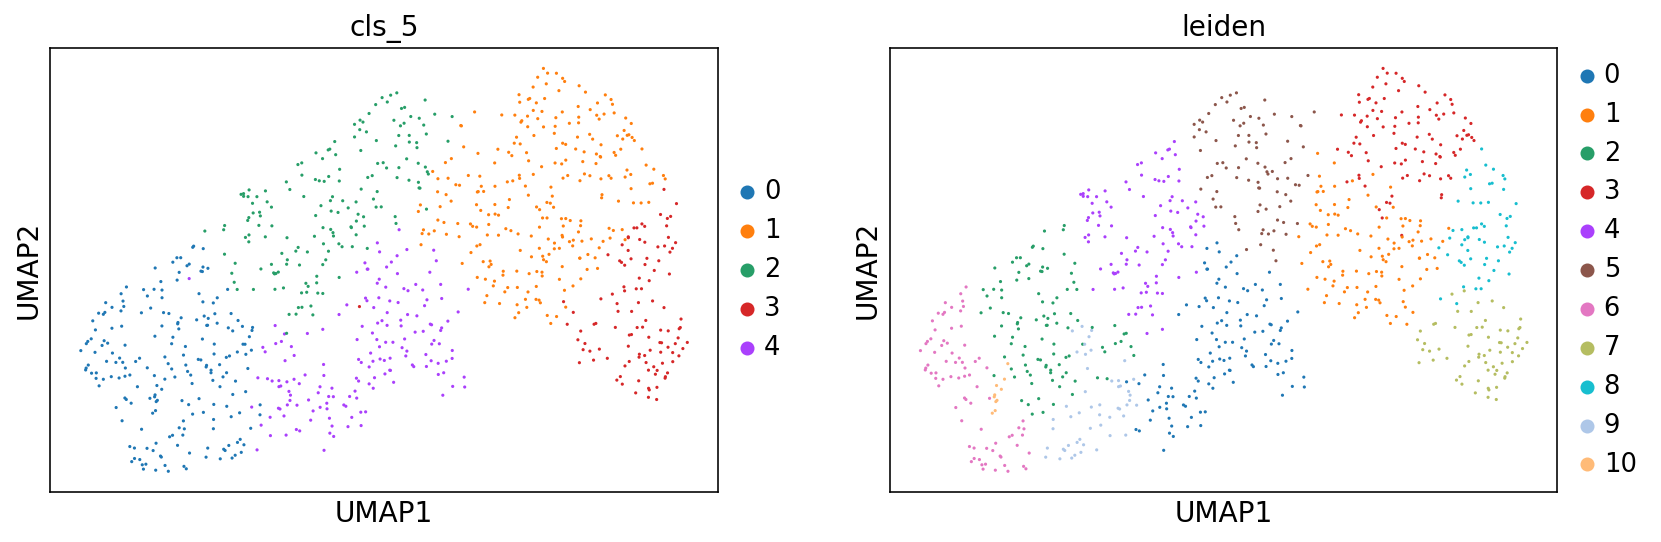

In [16]:
sc.pp.neighbors(a,use_rep=cur_exp_name+'_rep',metric='cosine',n_neighbors=30)
sc.tl.leiden(a)
sc.tl.umap(a)
sc.pl.umap(a,color=[cur_exp_name,'leiden'],s=10)

In [159]:
cur_exp_name = 'cls_5_pca'

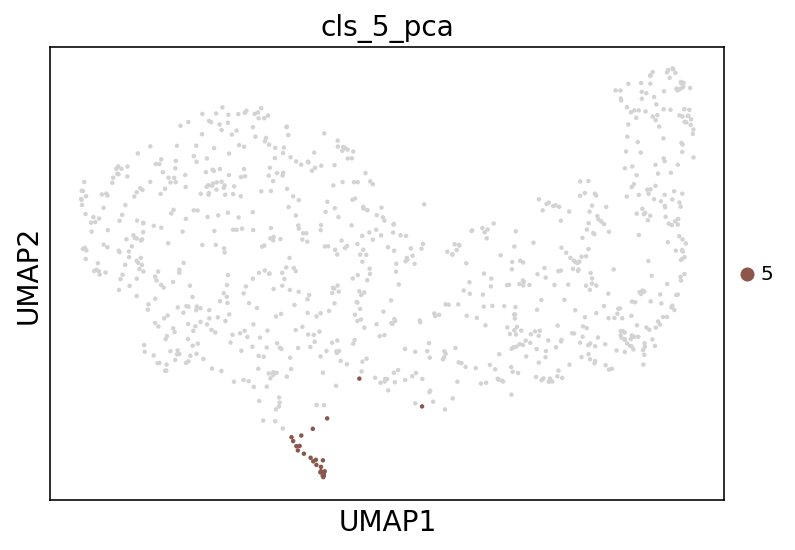

In [231]:
sc.pl.umap(a,color=[cur_exp_name],projection='2d',size=20,legend_fontsize=10,groups='5')


In [239]:
cur_exp_name

'cls_5_pca'

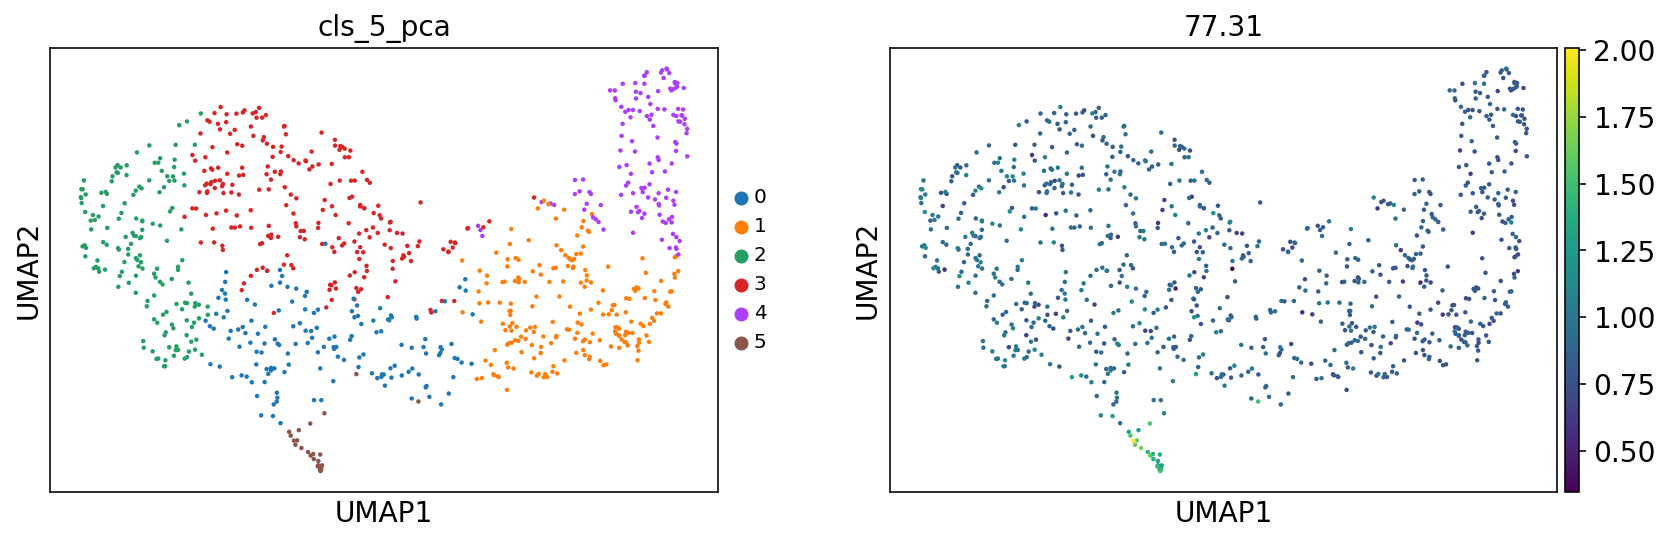

In [240]:
sc.pl.umap(a,color=[cur_exp_name,'77.31'],projection='2d',size=20,legend_fontsize=10)


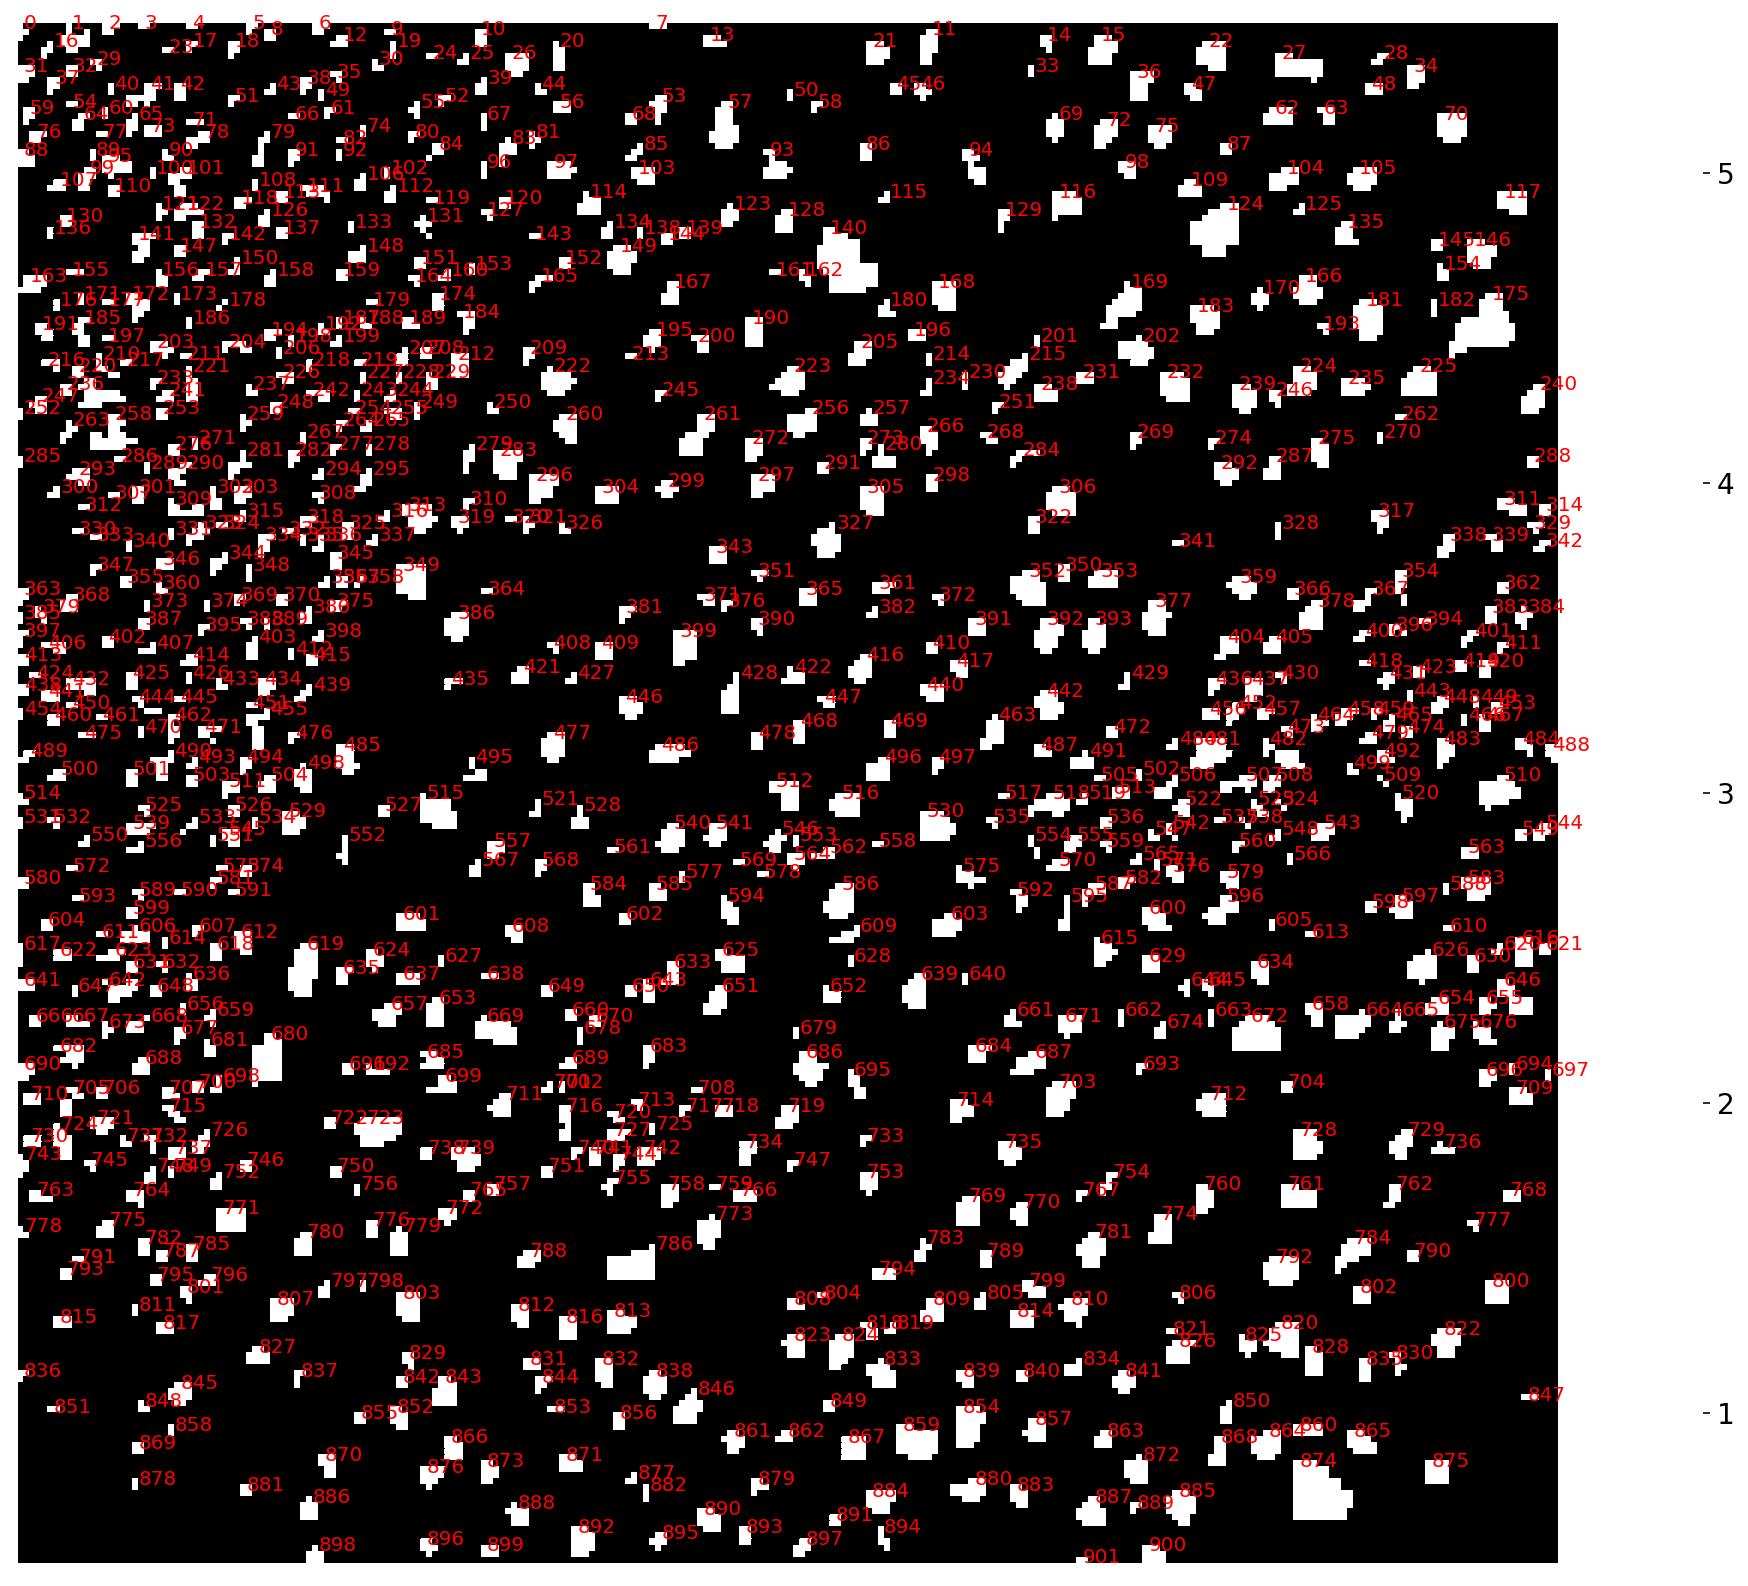

In [122]:
mask_cmp = ['w']*5
plot_label_image(a.obs['cls_5'],mask_cmp,mask=range(5),save=None,figsize=(15,15),anno=True)


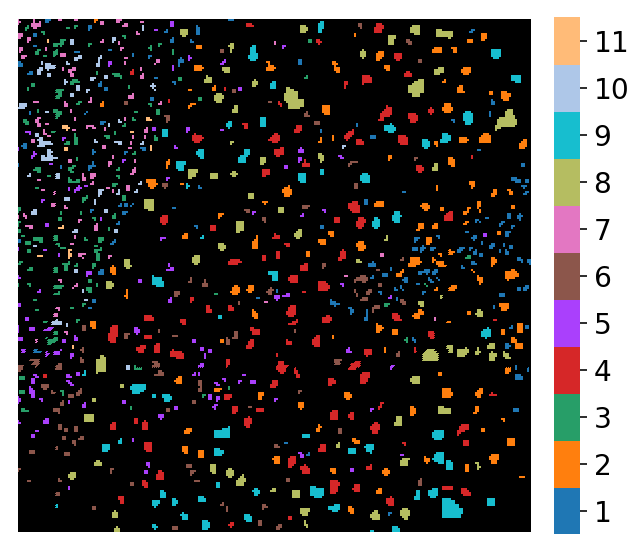

In [17]:
plot_label_image(a.obs['leiden'],a.uns['leiden'+'_colors'],mask=None,save=None)


In [18]:
a

AnnData object with n_obs × n_vars = 902 × 228 
    obs: 'cls_5', 'leiden'
    uns: 'rep_list', 'cls_5_colors', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_umap', 'cls_5_rep'

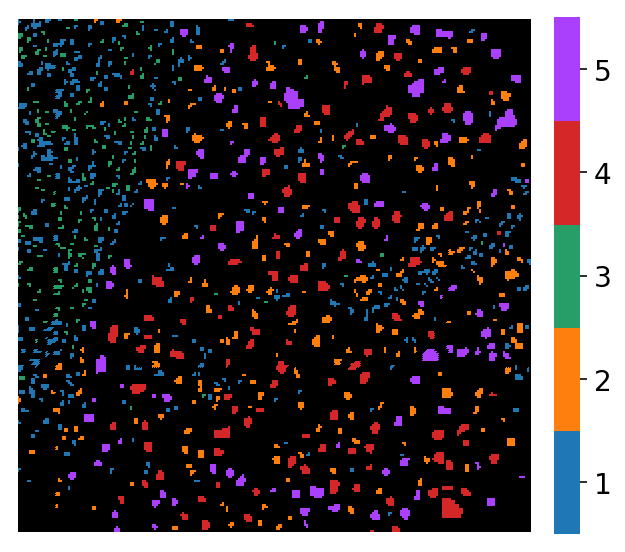

In [181]:
# cur_exp_name = 'cls_5'
plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=None,save=None)


In [124]:
# 60.28,61.28,76.31,77.31,
ec_cls = [568,750,738,364,527,322,270,214,679,882,558,284,693,554,553,527,754,891]

In [125]:
np.unique(a.obs[cur_exp_name])

array(['0', '1', '2', '3', '4'], dtype=object)

In [131]:
np.unique(a.obs[cur_exp_name+'_addec'][ec_cls])

array(['0', '1', '2', '3', '4'], dtype=object)

In [132]:
cur_exp_name

'cls_5_fc'

In [133]:
cls_5_fc_addec = a.obs[cur_exp_name].astype('str')
cls_5_fc_addec[ec_cls] = '5'
a.obs[cur_exp_name+'_addec'] = cls_5_fc_addec
a.obs[cur_exp_name+'_addec'] = a.obs[cur_exp_name+'_addec'].astype('category')

In [135]:
a.uns[cur_exp_name+'_colors'] = palettable.colorbrewer.qualitative.Set1_6.mpl_colors

In [243]:
cls_8_cmp = palettable.cartocolors.qualitative.Bold_8.mpl_colors

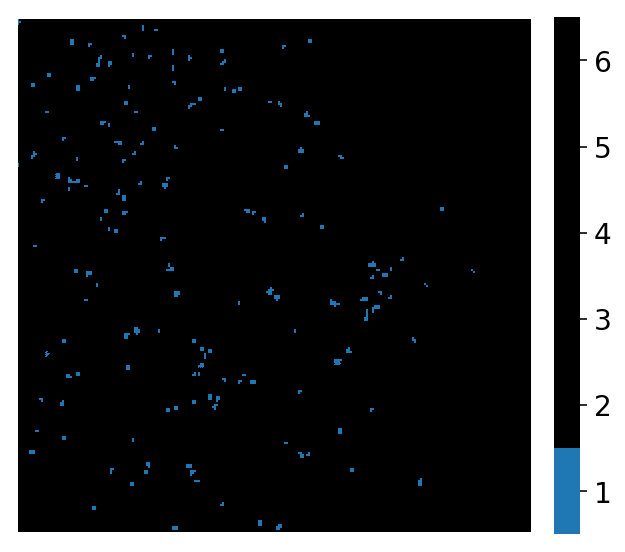

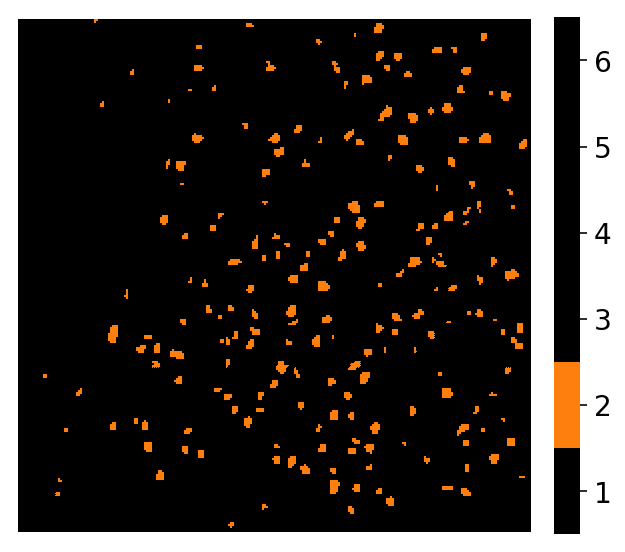

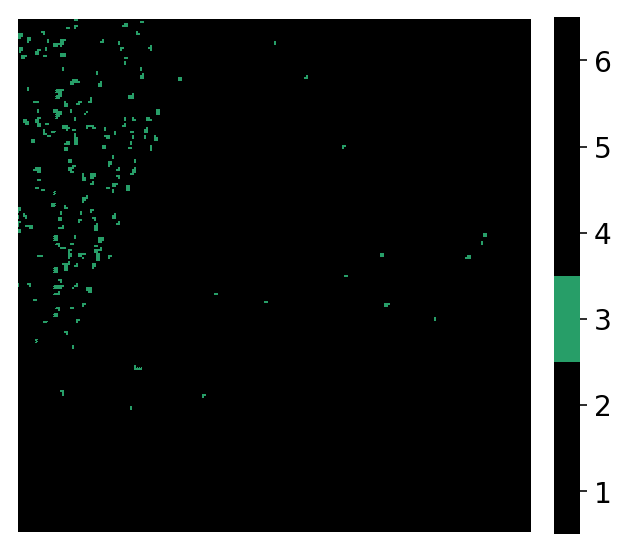

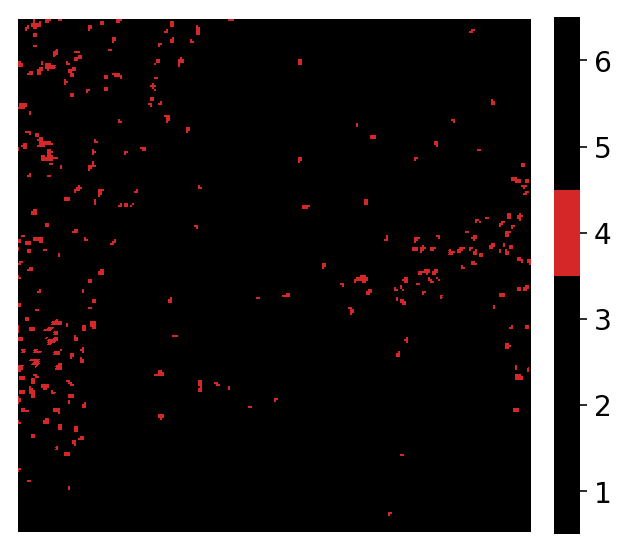

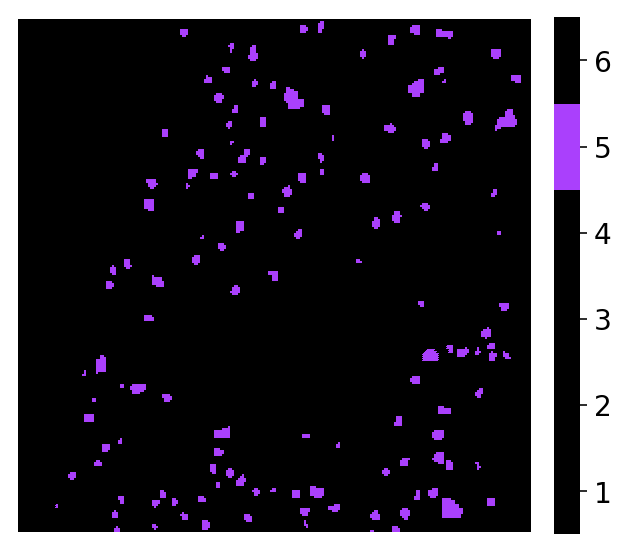

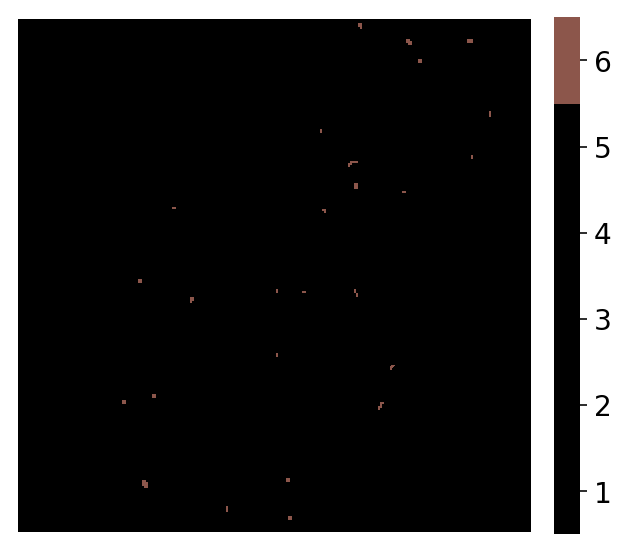

In [255]:
# cur_exp_name = 'cls_5_fc_addec'
# cur_exp_name = 'cls_5'
for i in range(6):
    plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=[i],save=None)
    


In [248]:
a.var_names

Index(['50.27', '51.28', '52.28', '53.28', '54.31', '55.29', '56.3', '57.28',
       '58.29', '59.3',
       ...
       '481.48', '483.45', '497.45', '499.45', '505.5', '521.45', '537.43',
       '539.39', '559.45', '577.44'],
      dtype='object', length=228)

In [ ]:
# 1:Fib(2)
# 2:Endo(5)
# 3:Kupf(0)
# 4:Immu(3)
# 5:Hepa(1)
# 6:Hepa69(4)

In [253]:
cur_pred = a.obs[cur_exp_name].copy()
cur_pred = np.array(cur_pred).astype('int')
reordered_pred = np.zeros_like(cur_pred)
reordered_pred[cur_pred==2]=1
reordered_pred[cur_pred==5]=2
reordered_pred[cur_pred==0]=3
reordered_pred[cur_pred==3]=4
reordered_pred[cur_pred==1]=5
reordered_pred[cur_pred==4]=6

In [256]:
a.obs[cur_exp_name+'_reorder'] = reordered_pred.astype('str')
a.obs[cur_exp_name+'_reorder'] = a.obs[cur_exp_name+'_reorder'].astype('category')

In [342]:
heatmap_cmp_mpl = palettable.cmocean.diverging.Balance_20.hex_colors

In [ ]:
heatmap_cmp_mpl

In [262]:
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [257]:
cur_exp_name = cur_exp_name+'_reorder'

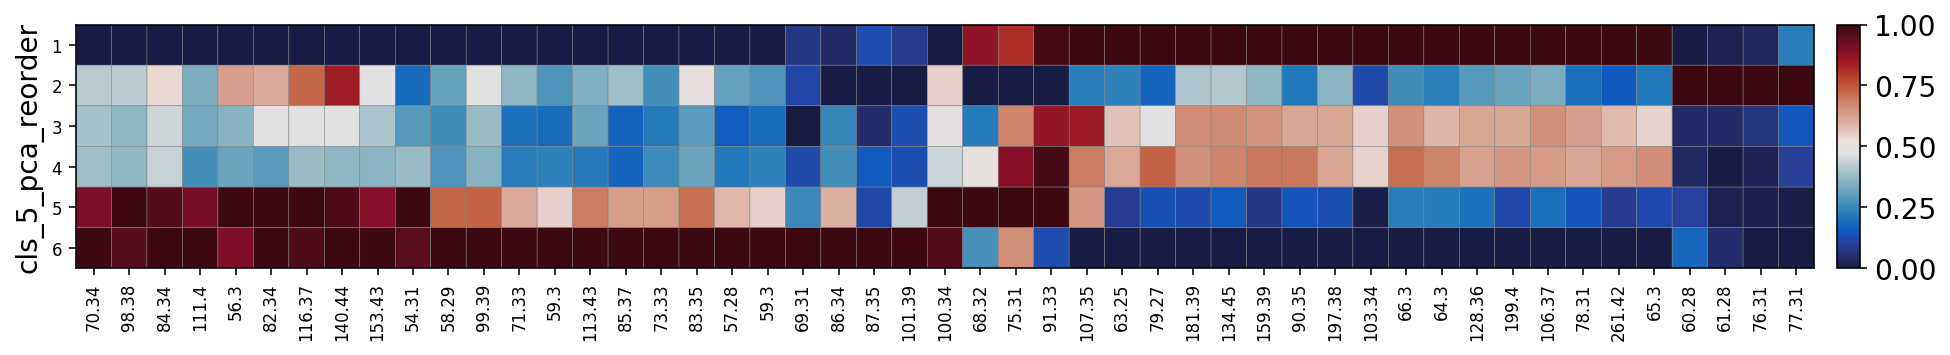

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[15.68, 0, 0.2])

In [263]:
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap

key_matters = get_adj_matters(key_matters,matter_list)
key_matters = np.array(key_matters).astype('str')
sc.pl.matrixplot(a,key_matters,groupby=cur_exp_name,standard_scale='var', cmap=heatmap_cmp,dendrogram=False,save=None)


In [234]:
sc.tl.rank_genes_groups(a,groupby=cur_exp_name,method='t-test')

ranking genes
    finished (0:00:00)


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_cls_5_pca']`


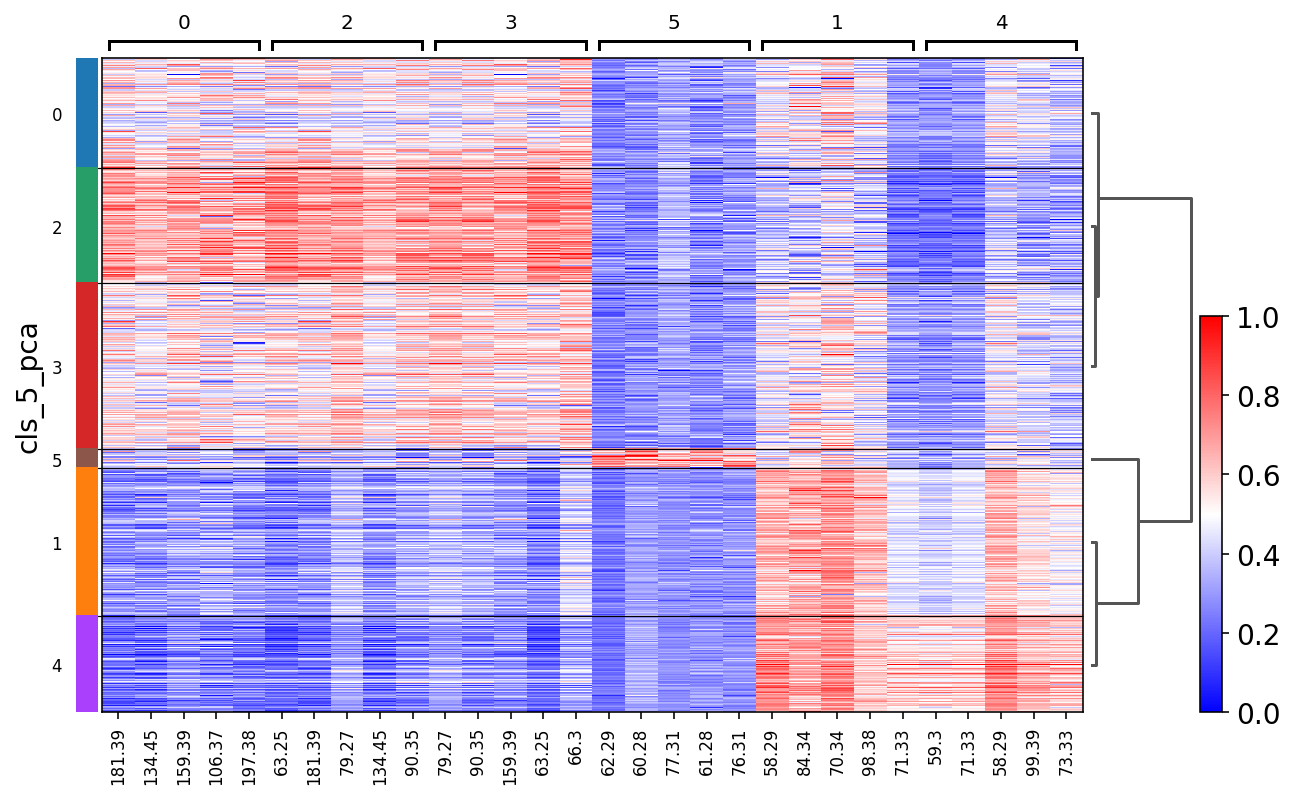

In [235]:
sc.pl.rank_genes_groups_heatmap(a,groupby=cur_exp_name,n_genes=5,standard_scale='var', cmap='bwr',dendrogram=True,save=None)


In [116]:
sc.tl.rank_genes_groups(a,groupby='cls_5_fc',method='t-test')

ranking genes
    finished (0:00:00)


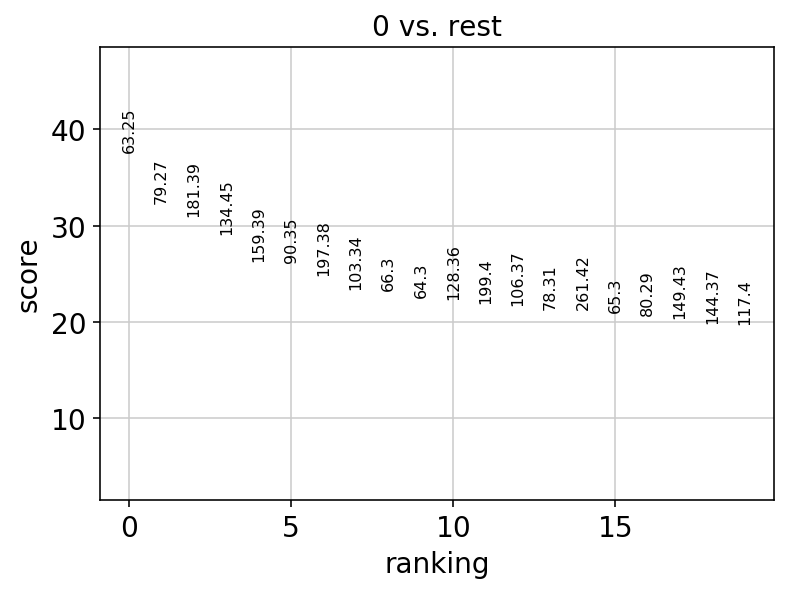

In [33]:
sc.pl.rank_genes_groups(a,groupby='cls_5',groups='0')

In [95]:
key_matters = [
#     Hepa
    70.34,98.38,84.34,111.4,56.3,82.34,116.37,140.44,153.43,54.31,
    
#     Hepa87+
    58.29,99.39,71.33,59.3,113.43,85.37,73.33,83.35,57.28,59.3,69.31,86.35,87.36,101.4,
    
#     Fib
    100.34,68.33,75.32,91.34,107.36,
    
#     nuclei
    63.25,79.27,181.39,134.45,159.39,90.35,197.38,103.34,66.3,64.3,128.36,199.4,106.37,78.31,261.42,65.3,
    
# Kupf/Endo
    60.28,61.28,76.31,77.31,
    
#     Immune cells
]

In [94]:
per_cls_max_matter_dict[1]

[52.28,
 54.31,
 56.3,
 68.32,
 98.38,
 100.34,
 110.4,
 116.37,
 118.38,
 122.4,
 123.39,
 124.41,
 126.42,
 136.42,
 138.43,
 140.44,
 142.44,
 152.43,
 154.45,
 156.46,
 164.43,
 166.45,
 167.46,
 169.48,
 170.47,
 178.44,
 180.43,
 187.45,
 194.48,
 195.5,
 202.48,
 206.49,
 209.5,
 211.52,
 231.45,
 233.5,
 259.53,
 293.43]

In [73]:
fib_matters = [100.34,107.35]
fib_matters = np.array(fib_matters).astype('str')

In [32]:
sc.pl.heatmap(a,fib_matters,groupby='cls_6',standard_scale='var', cmap='bwr',dendrogram=True,save=None)


NameError: name 'fib_matters' is not defined

In [35]:
matter_list_str = np.array(matter_list).astype('str')

In [294]:
unique_cls = np.unique(a.obs[cur_exp_name])
mean_cls_list = []
for c in unique_cls:
    cur_cls = np.array(a[a.obs[cur_exp_name]==c].X)
    cur_cls_mean = np.mean(cur_cls,axis=0)
    mean_cls_list.append(cur_cls_mean)
mean_cls_mat = np.vstack(mean_cls_list)

In [295]:
mean_cls_mat.shape

(6, 228)

In [55]:
mean_cls_mat_argmax = np.argmax(mean_cls_mat,axis=0)


In [58]:
mean_cls_mat_argmax

array([0, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 1, 3, 3, 3,
       3, 3, 3, 4, 4, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 4, 0, 0,
       0, 3, 0, 0, 1, 3, 1, 3, 0, 0, 0, 0, 0, 4, 0, 3, 1, 3, 0, 3, 3, 3,
       1, 0, 1, 3, 0, 0, 1, 1, 1, 0, 1, 3, 0, 3, 0, 0, 0, 0, 0, 0, 1, 3,
       1, 0, 1, 3, 1, 0, 0, 4, 0, 0, 0, 0, 0, 3, 1, 3, 1, 3, 1, 3, 0, 0,
       0, 4, 4, 3, 1, 0, 1, 1, 3, 1, 1, 3, 0, 3, 4, 3, 0, 0, 1, 3, 1, 0,
       0, 0, 0, 0, 2, 1, 0, 3, 2, 3, 0, 3, 1, 1, 0, 0, 0, 0, 1, 0, 4, 0,
       1, 0, 0, 1, 0, 1, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 4, 1, 1, 2, 0,
       0, 0, 2, 3, 2, 1, 0, 2, 3, 2, 3, 0, 1, 3, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 4, 0, 2, 0, 0, 0, 4, 0, 0, 3, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0,
       2, 0, 4, 0, 0, 2, 0, 0])

In [66]:
per_cls_max_matter_dict = {'0':1}


In [69]:
per_cls_max_matter_dict.get('1') is None

True

In [296]:
per_cls_max_matter_dict = {}

mean_cls_mat_argmax = np.argmax(mean_cls_mat,axis=0)
for i in range(matter_list.shape[0]):
    m = matter_list[i]
    cur_max_idx = mean_cls_mat_argmax[i]
    if per_cls_max_matter_dict.get(cur_max_idx) is None:
        per_cls_max_matter_dict[cur_max_idx] = [m]
    else:
        per_cls_max_matter_dict[cur_max_idx].append(m)

In [118]:
len(per_cls_max_matter_dict)

5

In [297]:
matter_list_str_order = []
for k in range(len(per_cls_max_matter_dict)):
    cur_list = per_cls_max_matter_dict[k]
    matter_list_str_order.extend(cur_list)
matter_list_str_order = np.array(matter_list_str_order).astype('str')

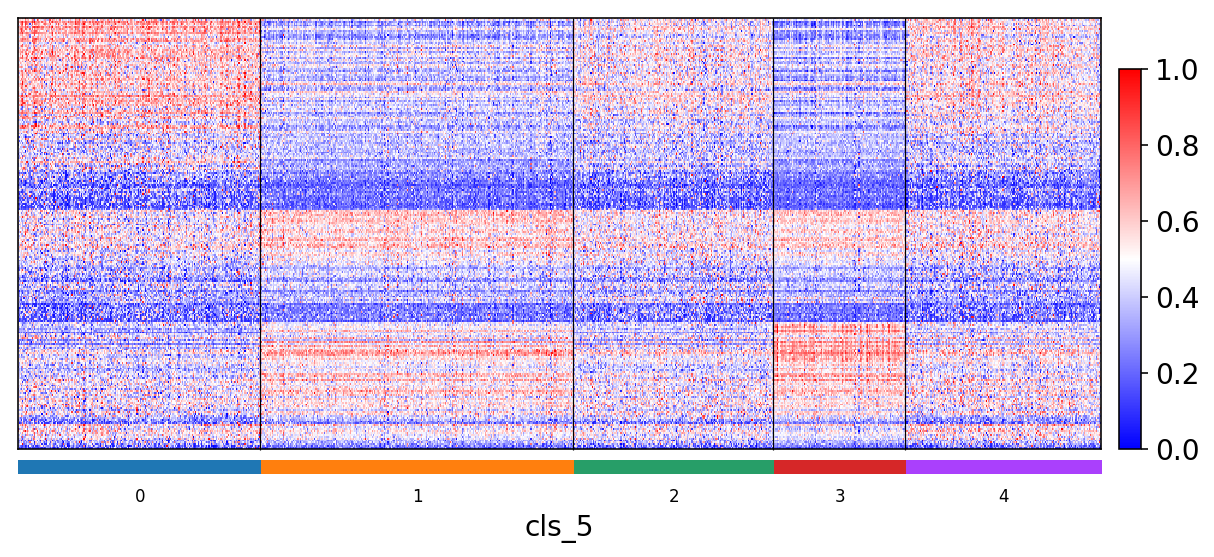

GridSpec(3, 3, height_ratios=[0, 4, 0.13], width_ratios=[10, 0, 0.2])

In [91]:
sc.pl.heatmap(a,matter_list_str_order,groupby='cls_5',standard_scale='var', cmap='bwr',dendrogram=False,save=None,swap_axes=True,)


In [289]:
per_cls_max_matter_dict[2]

[186.46,
 190.47,
 212.52,
 214.44,
 219.5,
 227.53,
 237.54,
 247.45,
 255.75,
 277.47,
 281.81,
 333.44,
 355.42,
 365.46,
 421.42,
 435.44,
 441.45,
 457.45,
 475.45,
 497.45,
 539.39]

In [293]:
per_cls_max_matter_dict[4]

[75.31,
 76.31,
 91.33,
 107.35,
 145.41,
 161.41,
 162.41,
 174.46,
 204.49,
 229.47,
 357.45,
 395.44,
 505.5]

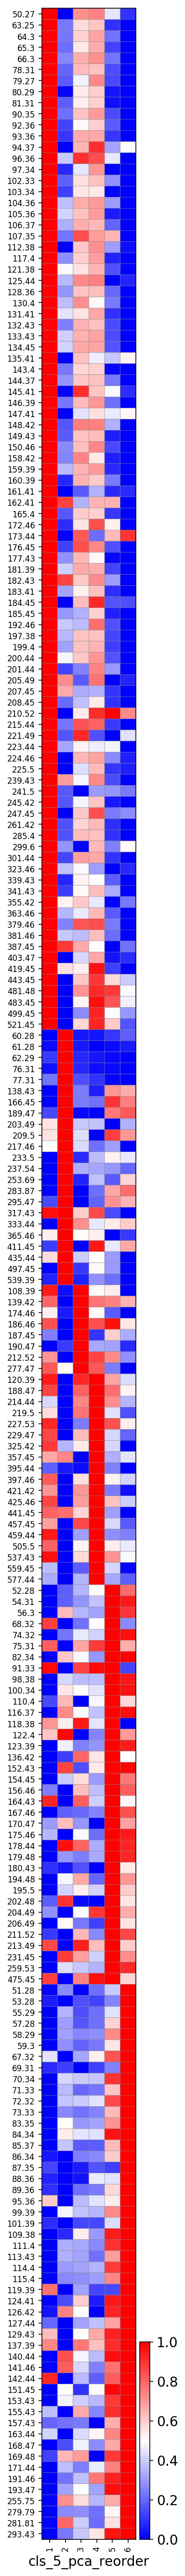

GridSpec(2, 3, height_ratios=[0, 45.6], width_ratios=[1.7999999999999998, 0, 0.2])

In [298]:
sc.pl.matrixplot(a,matter_list_str_order,groupby=cur_exp_name,standard_scale='var', cmap='bwr',dendrogram=False,save=None,swap_axes=True)


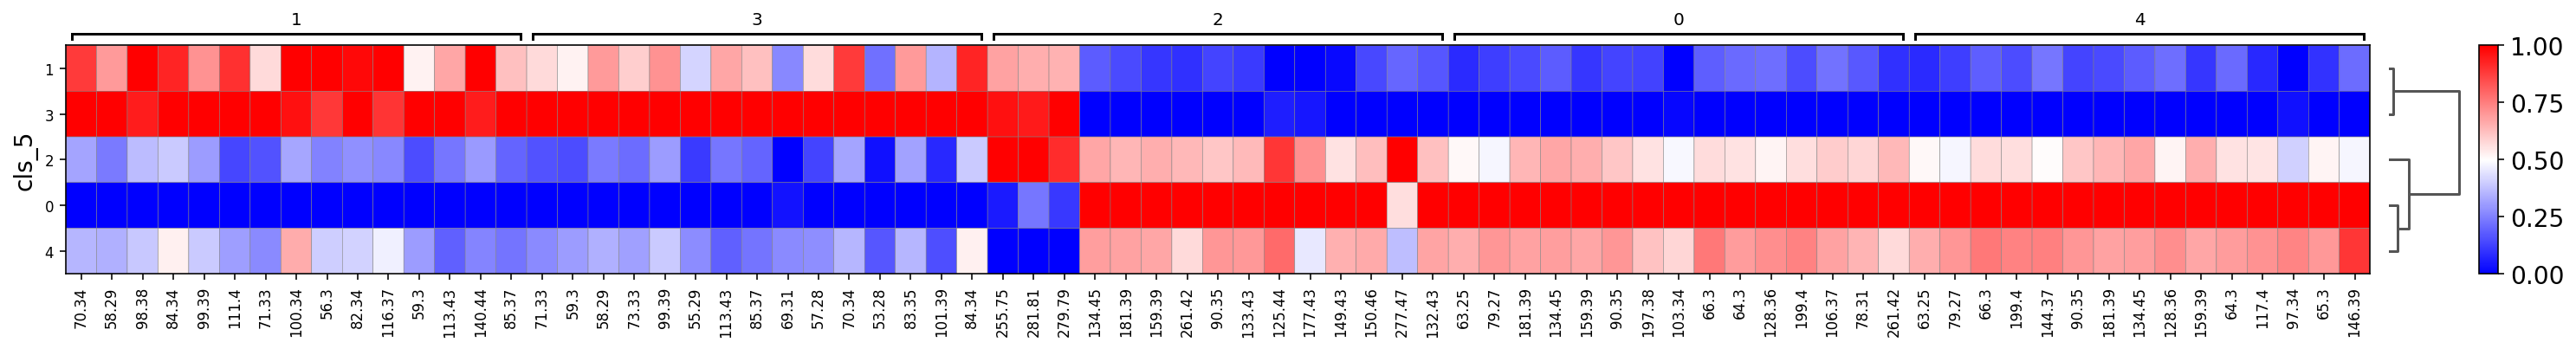

In [29]:
sc.pl.rank_genes_groups_matrixplot(a,groupby='cls_5',n_genes=15,standard_scale='var', cmap='bwr',dendrogram=True,save=None)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cls_5_fc']`


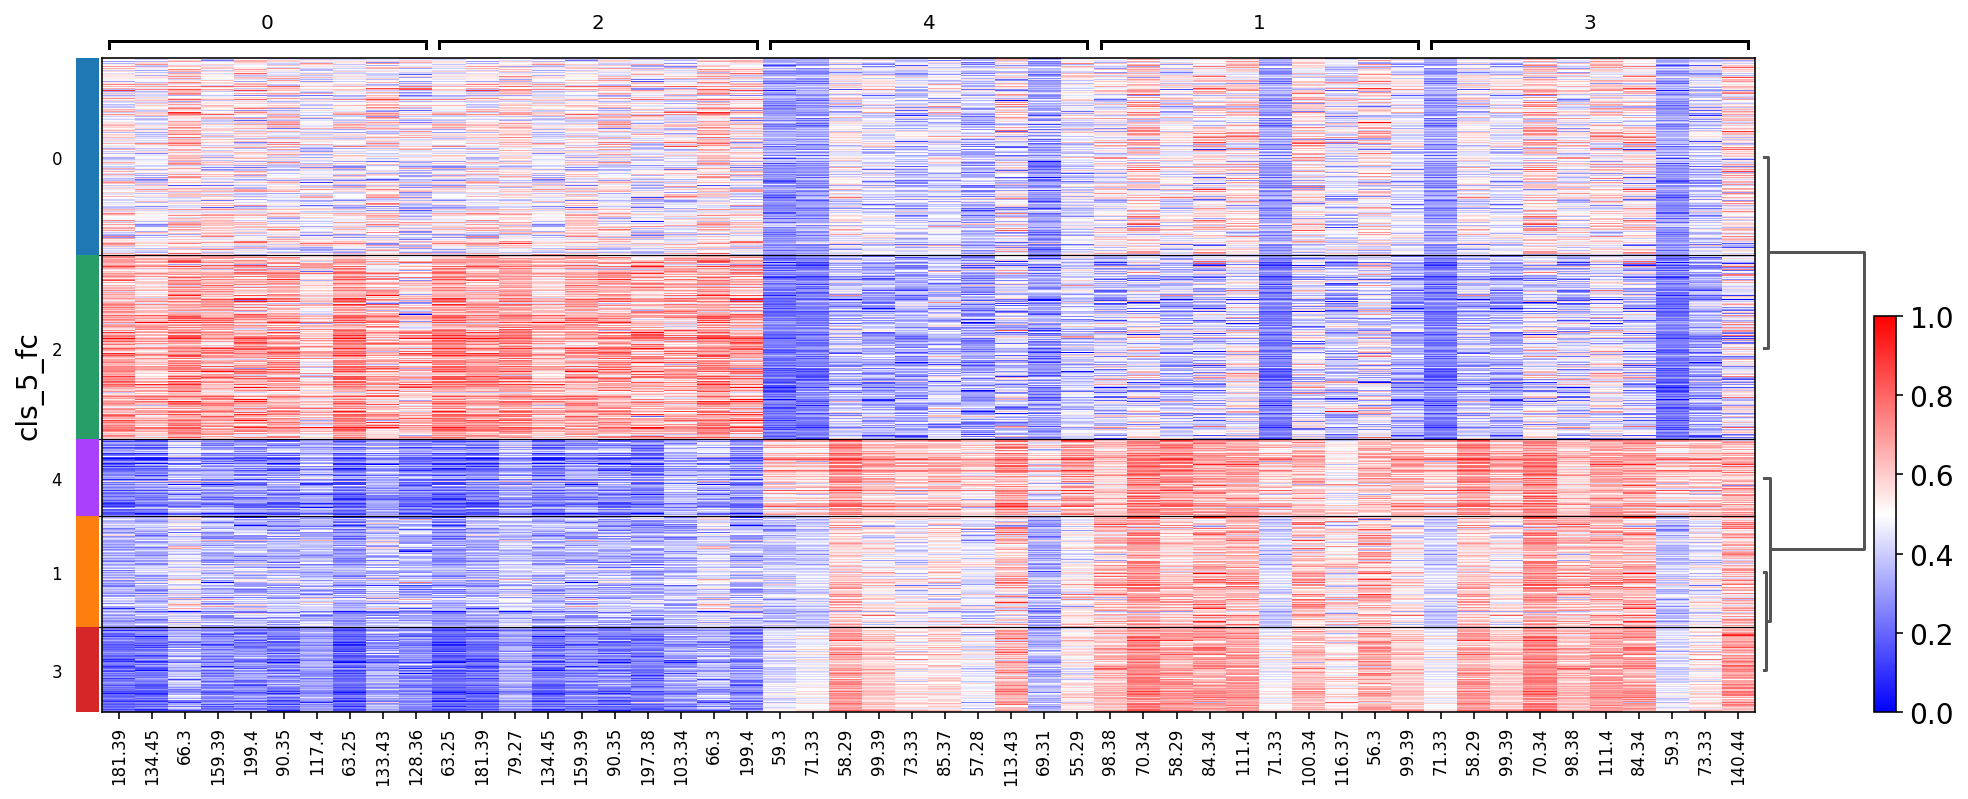

In [117]:
sc.pl.rank_genes_groups_heatmap(a,groupby='cls_5_fc',n_genes=10,standard_scale='var', cmap='bwr',dendrogram=True,save=None)


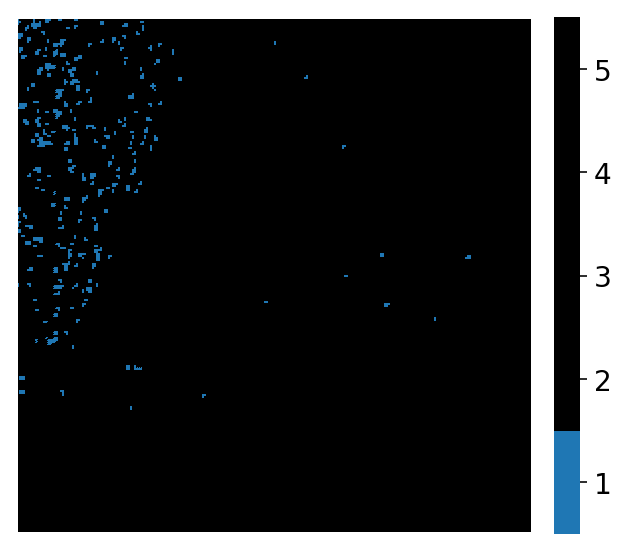

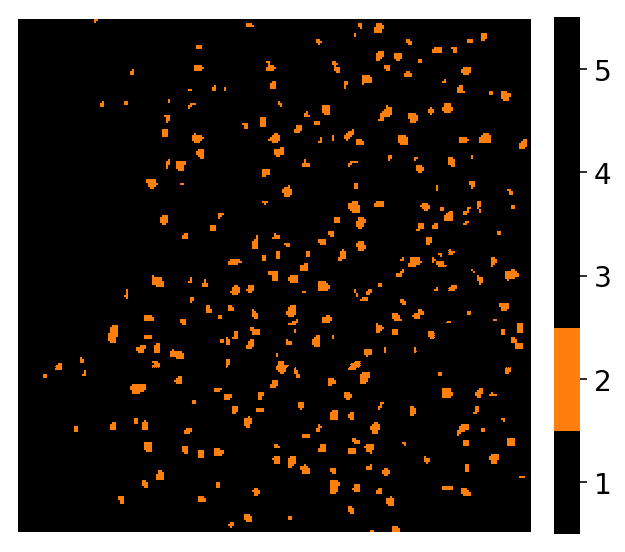

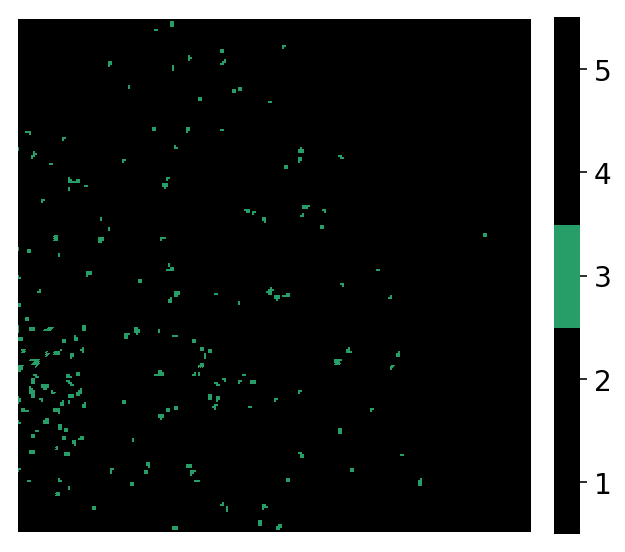

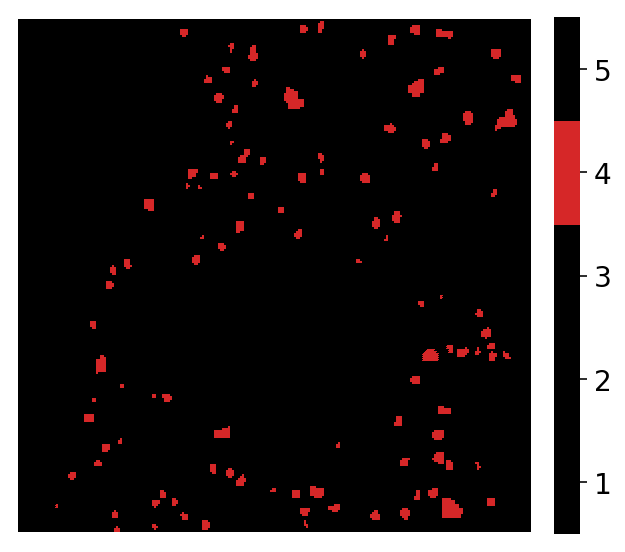

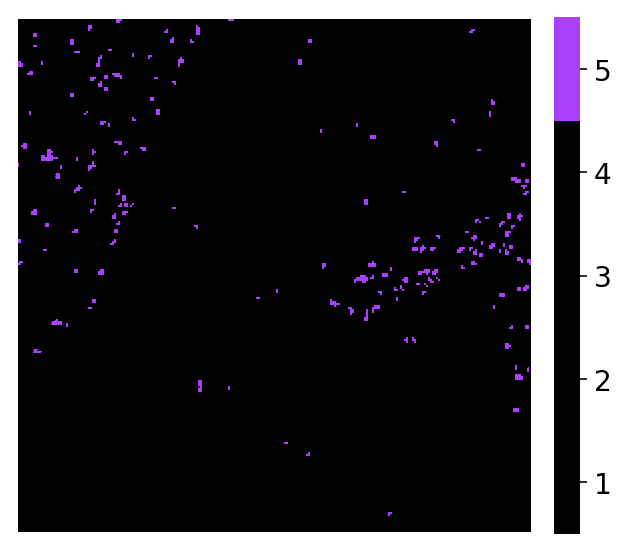

In [32]:
for i in range(5):
    plot_label_image(a.obs['cls_5'],a.uns['cls_5_colors'],mask=[i],save=None)
    


## data loading

In [15]:
data_mat_filename_temp = '/home/yzy/bioSIMS/data/process/{0}/cut/rst/datamat.mat'
matter_list_filename_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/matters_candidate.pkl'


# data='mouse0_liver0_neg1_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'
data = 'P6_neg1_low0_None_auto'
test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_228.mat'



matter_list_filename = matter_list_filename_temp.format(data)
data_mat_filename = data_mat_filename_temp.format(data)
test_sample_filename = test_sample_temp.format(data)
test_sample_all = sio.loadmat(test_sample_filename)['test_samples']
mode='none'
norm='none'
[original_data,cell_related_data]=get_train_data(data_mat_filename,mode,norm,batch_num_list=[1])
train_x=cell_related_data['train_x']
cell_idx=cell_related_data['cell_idx']
cell_pos=cell_related_data['cell_pos']

In [10]:
# a = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/fig4_c4.h5ad')
# f = open('figures/Fig4_dump_data/fig4_cluster4_add.pkl', 'rb') 
# a = pickle.load(f)
a = ad.read_h5ad('figures/Fig4_dump_data/fig4_rep1_cls5_reorder_full.h5ad')


In [10]:
cls_4 = np.array(a.obs['pred'])
cls_4[cls_4=='4']='2'
cls_4[cls_4=='5']='4'
a.obs['cls_4'] = cls_4

## color setting

In [268]:
# 1:Fib(2)
# 2:Endo(5)
# 3:Kupf(0)
# 4:Immu(3)
# 5:Hepa(1)
# 6:Hepa69(4)

cls_cmp = palettable.cartocolors.qualitative.Bold_8.mpl_colors
cls_cmp = [cls_cmp[0],cls_cmp[1],cls_cmp[3],cls_cmp[6],cls_cmp[7],cls_cmp[4]]
a.uns[cur_exp_name+'_colors'] = cls_cmp

## reorder and color setting

In [204]:
# Hepa69+,Hepa69-,Kupf,Endo,Fib,IM，
cls_order = np.array(a_rep1_heatmap.obs['test'].copy()).astype('int')
cls_order_tmp = cls_order.copy()

cls_order[cls_order_tmp==5]=1
cls_order[cls_order_tmp==4]=2
cls_order[cls_order_tmp==3]=3
cls_order[cls_order_tmp==2]=4
cls_order[cls_order_tmp==1]=5
cls_order[cls_order_tmp==6]=6

cls_order = cls_order.astype('str')

a_rep1_heatmap.obs['test_reorder'] = cls_order
a_rep1_heatmap.obs['test_reorder'] = a_rep1_heatmap.obs['test_reorder'].astype('category')



In [205]:
fluo_colors = [
    (255/255, 0, 92/255),
    (104/255, 255/255, 0),
    (250/255, 255/255, 0),
    (19/255, 244/255, 239/255),
    (0, 111/255, 255/255),
    (255/255, 191/255, 0),
    
    
    
    
]
a_rep1_heatmap.uns['test_reorder_colors'] = fluo_colors

In [258]:
# Hepa69+,Hepa69-,Kupf,Endo,Fib,IM，
cls_order = np.array(a_rep1_heatmap.obs['test_reorder'].copy()).astype('int')
cls_order_tmp = cls_order.copy()

# cls_order[cls_order_tmp==5]=1
# cls_order[cls_order_tmp==4]=2
# cls_order[cls_order_tmp==3]=3
# cls_order[cls_order_tmp==2]=4
cls_order[cls_order_tmp==4]=6
cls_order[cls_order_tmp==6]=4

cls_order = cls_order.astype('str')

a_rep1_heatmap.obs['test_reorder'] = cls_order
a_rep1_heatmap.obs['test_reorder'] = a_rep1_heatmap.obs['test_reorder'].astype('category')



In [260]:
fluo_colors = [
    (255/255, 0, 92/255),
    (104/255, 255/255, 0),
    (250/255, 255/255, 0),
    (255/255, 191/255, 0),
    
    (0, 111/255, 255/255),
    (19/255, 244/255, 239/255),
    
    
    
    
]
a_rep1_heatmap.uns['test_reorder_colors'] = fluo_colors

## new join dist analysis 

In [15]:
dist_data_dump_path = 'figures/Supp/{0}/data.h5ad'
sample_list  ='P19_R2'

a_tmp = ad.read_h5ad(dist_data_dump_path.format(sample_list))[:,0]

100
200
300
400
500
P1 [0.42262601210982564, 0.0020778454340023653, 1.0298556736161558e-07, 7.152432324783166e-09, 7.152432324783166e-09]


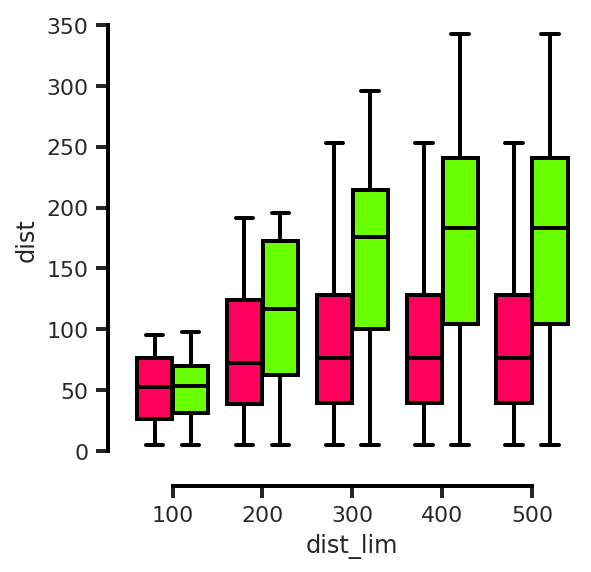

100
200
300
400
500
P2 [0.0004774348070875672, 0.0026427985455275593, 0.04841886736861531, 0.04841886736861531, 0.04841886736861531]


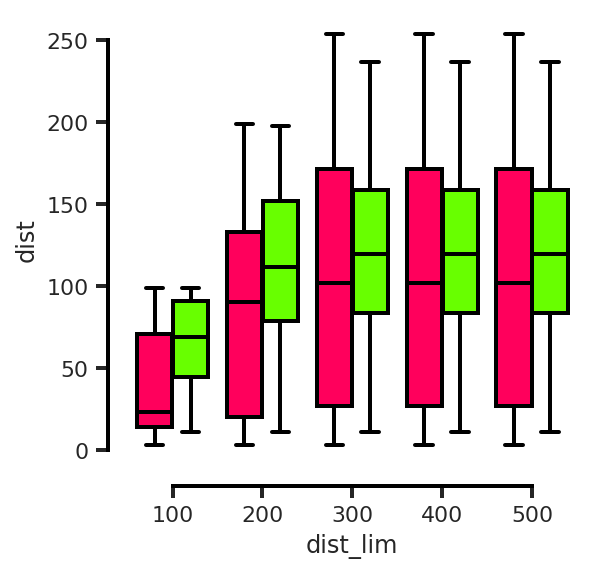

100
200
300
400
500
P3_R3 [0.7907816020799653, 0.14220559590616577, 0.023889323803100233, 0.023889323803100233, 0.023889323803100233]


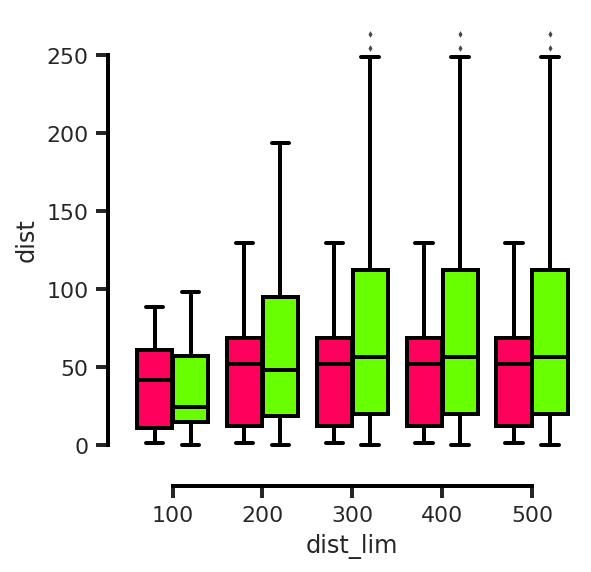

100
200
300
400
500
P3_R4 [0.5703890854440442, 0.008067937339798235, 0.004296626890935646, 0.004296626890935646, 0.004296626890935646]


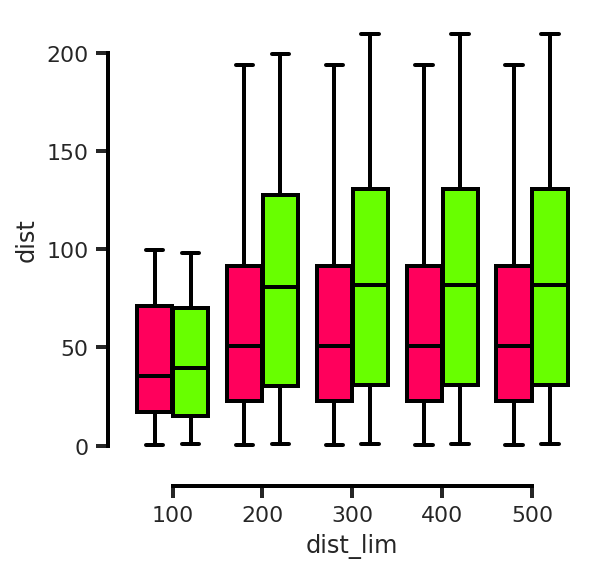

100
200
300
400
500
P3_R5 [7.117929181368709e-06, 0.04959748082937369, 0.04959748082937369, 0.04959748082937369, 0.04959748082937369]


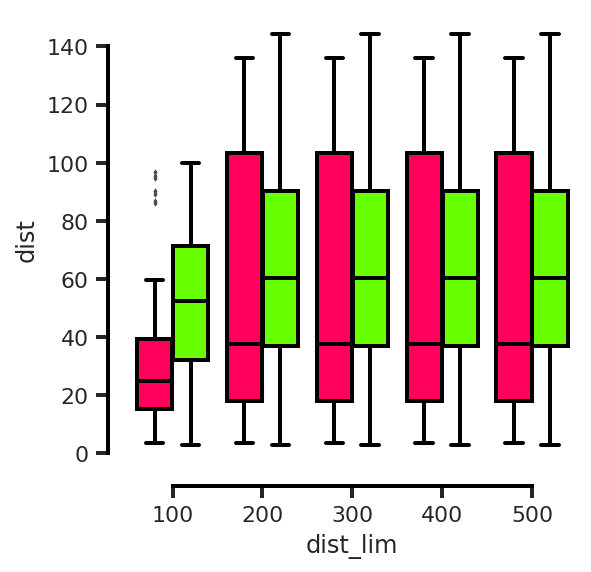

100
200
300
400
500
P5 [0.20507821688973932, 0.0005831591300549989, 0.13808854309363966, 0.13808854309363966, 0.13808854309363966]


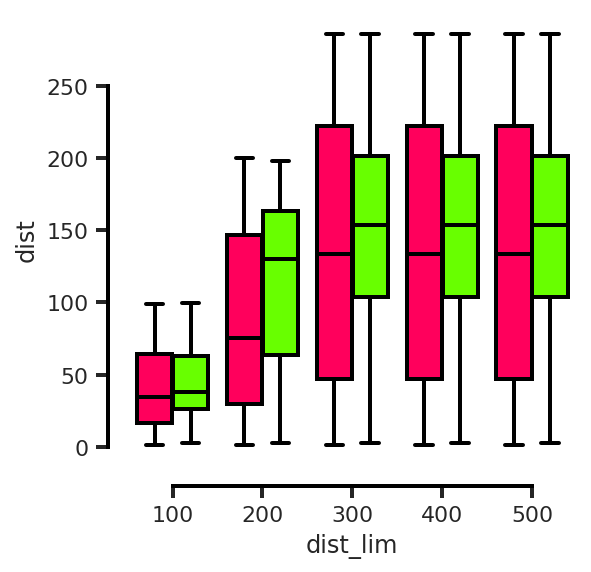

100
200
300
400
500
P19_R1 [0.3186120216934125, 0.01080056685018821, 0.019991366444016456, 0.01013948455566031, 0.01013948455566031]


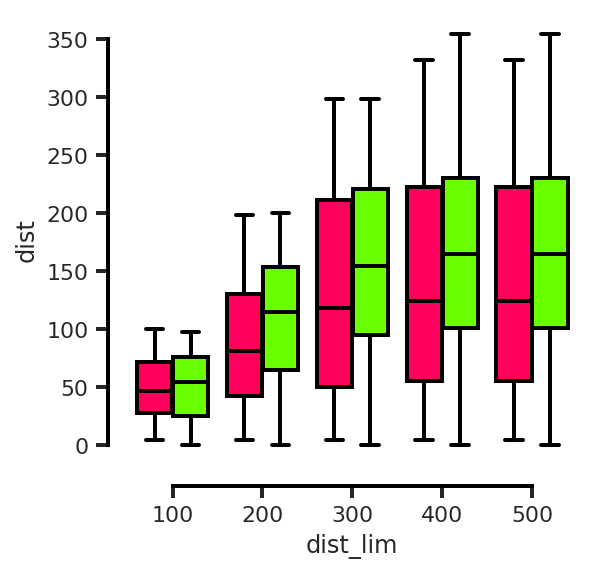

100
200
300
400
500
P19_R2 [0.001940568453890648, 0.041923978210291764, 0.0008513473518657235, 0.0006387335997500933, 0.0006387335997500933]


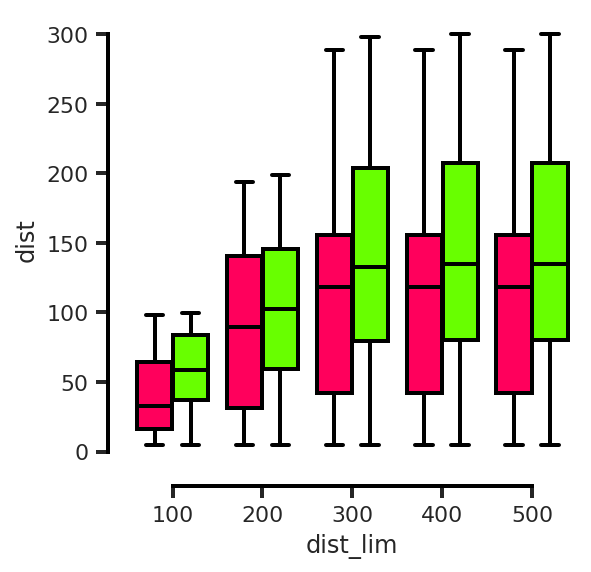

100
200
300
400
500
P19_R3 [0.9816165983060099, 0.8750973003937692, 0.773422313175737, 0.3483463050263051, 0.4558877071563932]


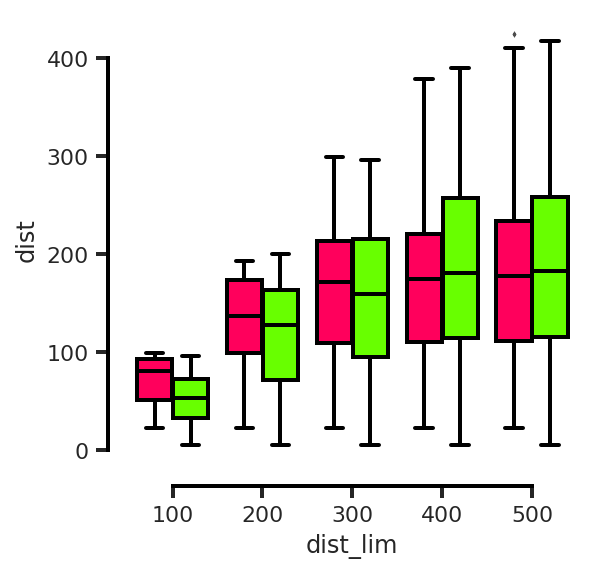

100
200
300
400
500
P19_R4 [0.6031373960913986, 0.23198252485077603, 0.12722419686340808, 0.12722419686340808, 0.12722419686340808]


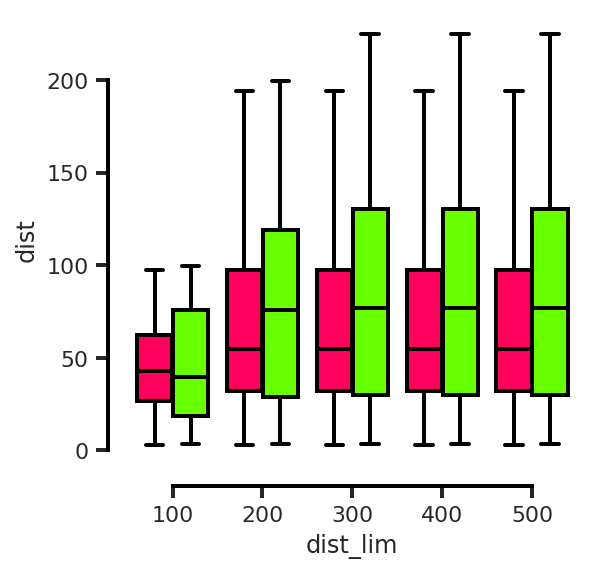

In [24]:
dist_data_dump_path = 'figures/Supp/{0}/data.h5ad'

sample_list  =['P1','P2','P3_R3','P3_R4','P3_R5','P5','P19_R1','P19_R2','P19_R3','P19_R4']
hepa_69_idx_list = ['6','6','6','6','6','6','6','6','6','6']
hepa_normal_idx_list = ['5','5','5','5','5','5','5','5','4','5']


for i in range(len(sample_list)):
    sample_name = sample_list[i]
    
    hepa_69_idx = hepa_69_idx_list[i]
    hepa_normal_idx = hepa_normal_idx_list[i]
    cur_save= None
    
    cur_a = ad.read_h5ad(dist_data_dump_path.format(sample_name))[:,0]
    if 'exclude_dist' in cur_a.obs:
        cur_a = cur_a[cur_a.obs['exclude_dist']<0]
    thre_list,dist_ratio_list,p_val,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(cur_a,100,100,600)
#     thre_list,dist_ratio_list,p_val,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(cur_a,50,1,450,c_hep_normal=hepa_normal_idx,c_hep_87=hepa_69_idx)
    print(sample_name,p_val)
    plot_dist_box(hepa_dist_pd_dict,None)
    
#     plot_count_ratio(count_ratio_standard_list,thre_list,cur_save)


100
200
300
400
500
P1 [0.8383129936941109, 0.004111896059267553, 2.034050855858585e-07, 1.4125226719289625e-08, 1.4125226719289625e-08]


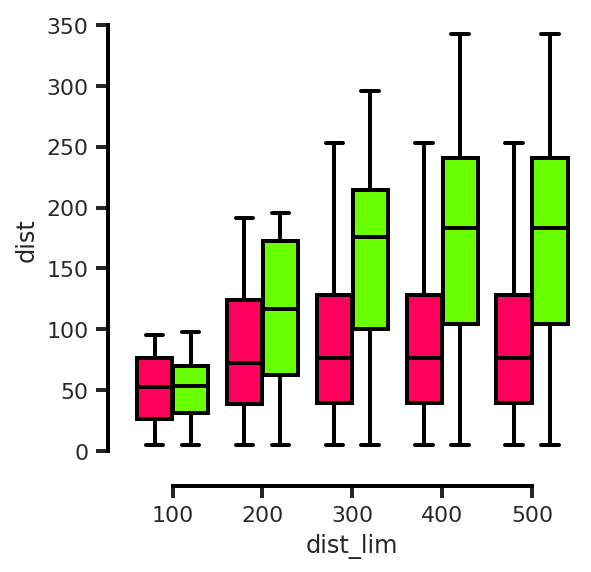

100
200
300
400
500
P2 [0.0009388997441823251, 0.005259145446882225, 0.09656554162221517, 0.09656554162221517, 0.09656554162221517]


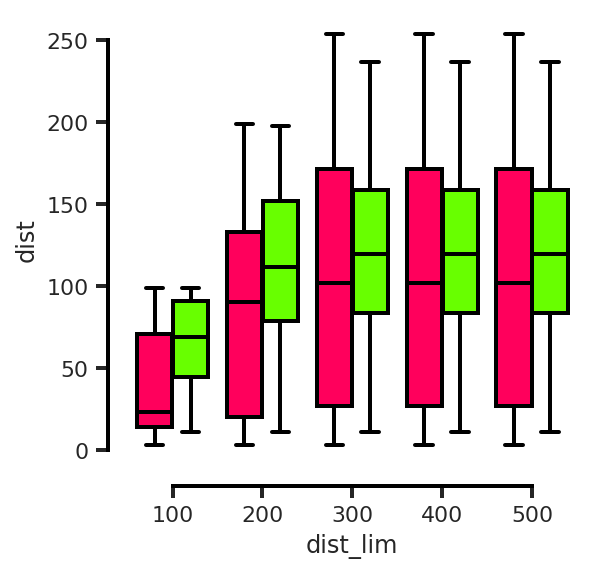

100
200
300
400
500
P3_R3 [0.42044686786074925, 0.283194520050281, 0.0475029578700147, 0.0475029578700147, 0.0475029578700147]


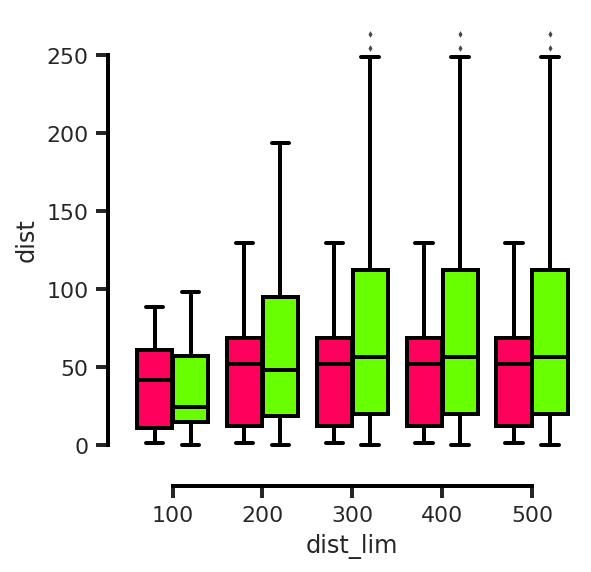

100
200
300
400
500
P3_R4 [0.8609638501357697, 0.016078151818298716, 0.008560777361375302, 0.008560777361375302, 0.008560777361375302]


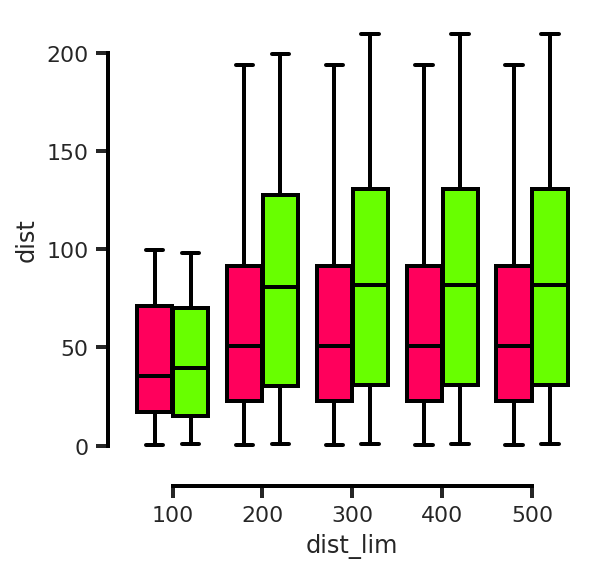

100
200
300
400
500
P3_R5 [1.410399814852121e-05, 0.09890722381389981, 0.09890722381389981, 0.09890722381389981, 0.09890722381389981]


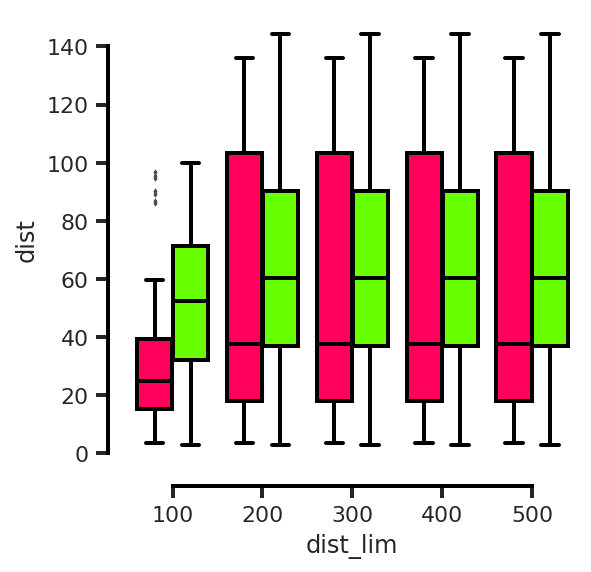

100
200
300
400
500
P5 [0.4080414588187473, 0.0011618324973952285, 0.2758845451135553, 0.2758845451135553, 0.2758845451135553]


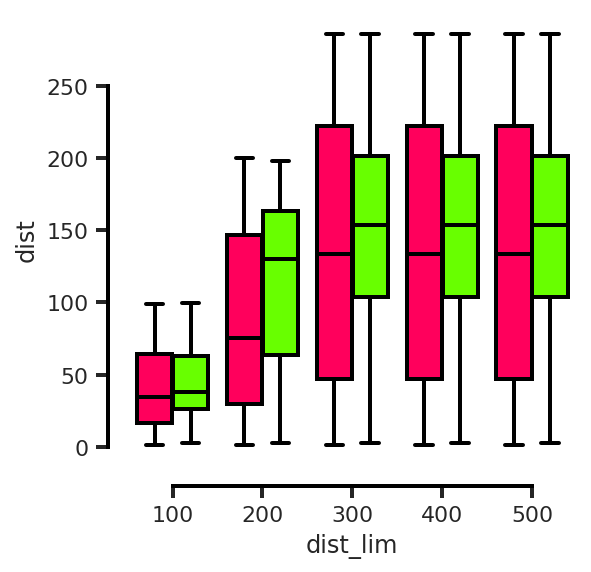

100
200
300
400
500
P19_R1 [0.6349354924548514, 0.021538977486839368, 0.039921691109421696, 0.020247988607287097, 0.020247988607287097]


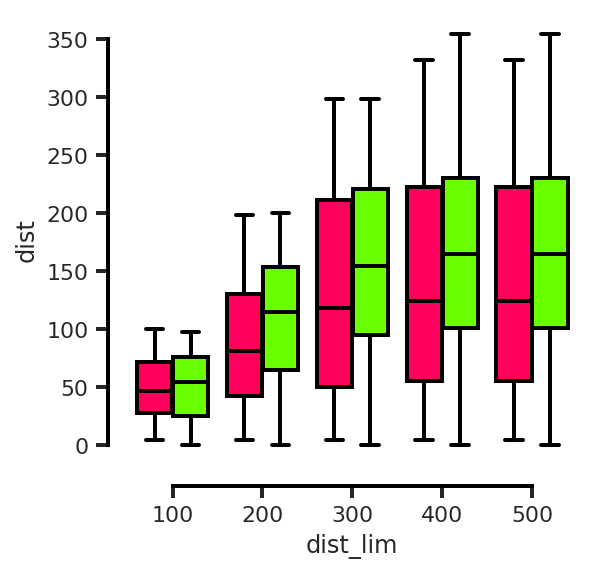

100
200
300
400
500
P19_R2 [0.003843919765704198, 0.08364764895705014, 0.0016981715426565539, 0.0012740149431467967, 0.0012740149431467967]


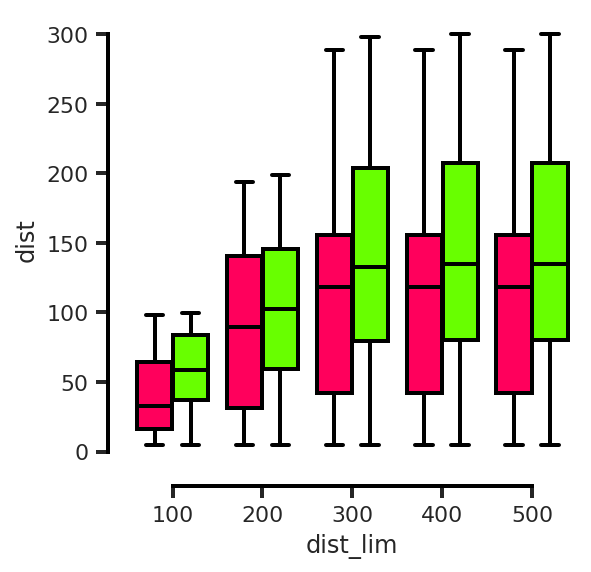

100
200
300
400
500
P19_R3 [0.03807555870827775, 0.25091093552306043, 0.454075961015349, 0.695747746474588, 0.9107882450543946]


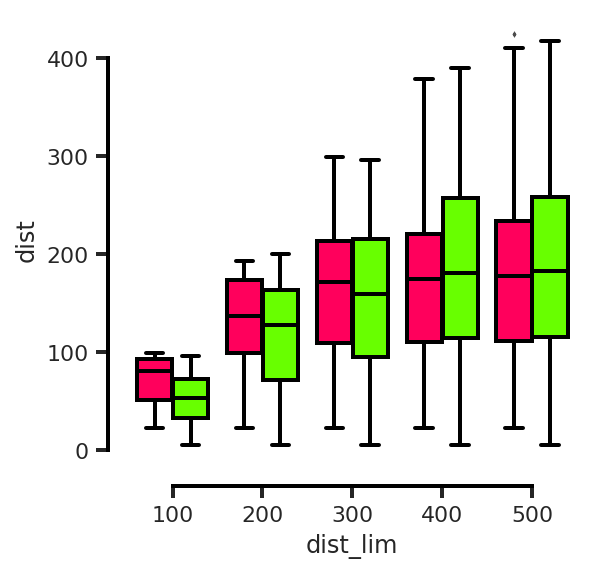

100
200
300
400
500
P19_R4 [0.7960435463362902, 0.4628677899301028, 0.2537261397551507, 0.2537261397551507, 0.2537261397551507]


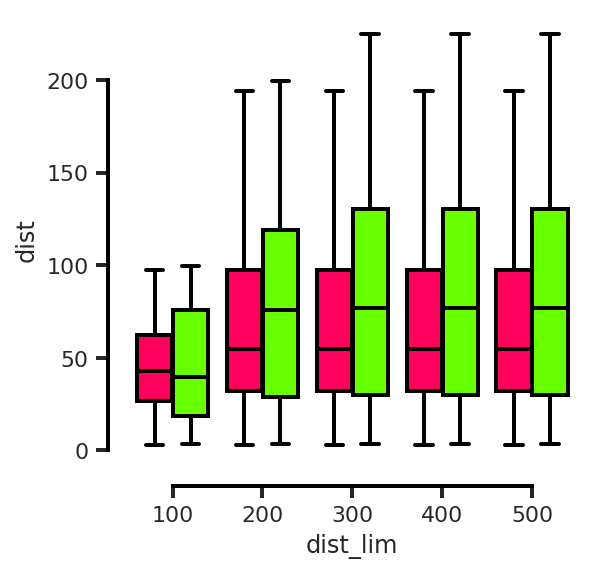

In [18]:
dist_data_dump_path = 'figures/Supp/{0}/data.h5ad'

sample_list  =['P1','P2','P3_R3','P3_R4','P3_R5','P5','P19_R1','P19_R2','P19_R3','P19_R4']
hepa_69_idx_list = ['6','6','6','6','6','6','6','6','6','6']
hepa_normal_idx_list = ['5','5','5','5','5','5','5','5','4','5']


for i in range(len(sample_list)):
    sample_name = sample_list[i]
    
    hepa_69_idx = hepa_69_idx_list[i]
    hepa_normal_idx = hepa_normal_idx_list[i]
    cur_save= None
    
    cur_a = ad.read_h5ad(dist_data_dump_path.format(sample_name))[:,0]
    if 'exclude_dist' in cur_a.obs:
        cur_a = cur_a[cur_a.obs['exclude_dist']<0]
    thre_list,dist_ratio_list,p_val,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(cur_a,100,100,600)
#     thre_list,dist_ratio_list,p_val,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(cur_a,50,1,450,c_hep_normal=hepa_normal_idx,c_hep_87=hepa_69_idx)
    print(sample_name,p_val)
    plot_dist_box(hepa_dist_pd_dict,None)
    
#     plot_count_ratio(count_ratio_standard_list,thre_list,cur_save)


In [11]:
dist_data_dump_path = 'figures/Supp/{0}/data.h5ad'

sample_list  =['P1','P2','P3_R3','P3_R4','P3_R5','P5','P19_R1','P19_R2','P19_R3','P19_R4']
hepa_69_idx_list = ['6','6','6','6','6','6','6','6','6','6']
hepa_normal_idx_list = ['5','5','5','5','5','5','5','5','4','5']

a_list = []
cur_save=None

for i in range(len(sample_list)):
    sample_name = sample_list[i]
    
    hepa_69_idx = hepa_69_idx_list[i]
    hepa_normal_idx = hepa_normal_idx_list[i]
    
    cur_a = ad.read_h5ad(dist_data_dump_path.format(sample_name))[:,0]
    if hepa_normal_idx=='4':
        cur_cls = np.array(cur_a.obs['final_cls'].copy())
        cur_cls_tmp = cur_cls.copy()
        cur_cls[cur_cls_tmp=='4']='5'
        cur_cls[cur_cls_tmp=='5']='4'
        cur_a.obs['final_cls'] = cur_cls
        cur_a.obs['final_cls'] = cur_a.obs['final_cls'].astype('category')
        
    
    
    if 'exclude_dist' in cur_a.obs:
        cur_a = cur_a[cur_a.obs['exclude_dist']<0]
    
    a_list.append(cur_a)
        
#         thre_list,dist_ratio_list,_,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(a_use,100,100,600)
    thre_list,dist_ratio_list,_,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(cur_a,50,1,450)
    plot_count_ratio(count_ratio_standard_list,thre_list,cur_save)
    
a_concat = a_list[0].concatenate(a_list[1:])
thre_list,dist_ratio_list,_,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(a_concat,50,1,450)
plot_count_ratio(count_ratio_standard_list,thre_list,cur_save)

thre_list,dist_ratio_list,dist_p_list,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(a_concat,100,100,600)
plot_dist_box(hepa_dist_pd_dict,cur_save)

 

# rep3_cls = np.array(a_rep3.obs['cls_6_bak_reorder'].copy())
# rep3_cls_tmp = rep3_cls.copy()
# rep3_cls[rep3_cls_tmp=='4']='5'
# rep3_cls[rep3_cls_tmp=='5']='4'


# a_rep3.obs['final_cls'] = rep3_cls
# a_rep3.obs['final_cls'] = a_rep3.obs['final_cls'].astype('category')


Trying to set attribute `.obs` of view, copying.


In [55]:
thre_list,dist_ratio_list,dist_p_list,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat_step(a_concat,50,10,400)


100
200
300


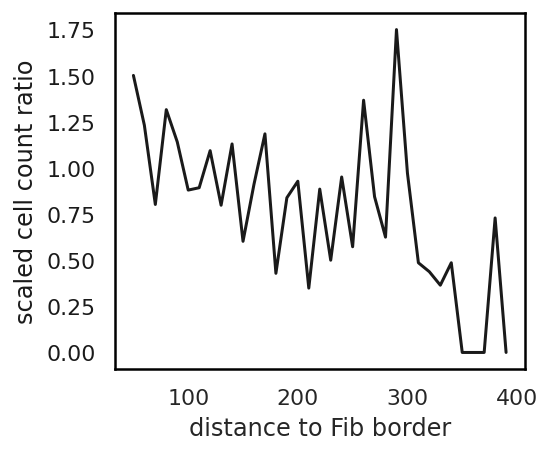

In [56]:
plot_count_ratio(count_ratio_standard_list,thre_list,None)


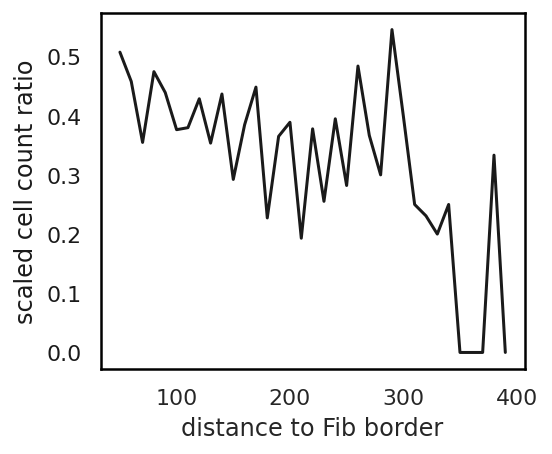

In [52]:
plot_count_ratio(count_ratio_standard_list,thre_list,None)


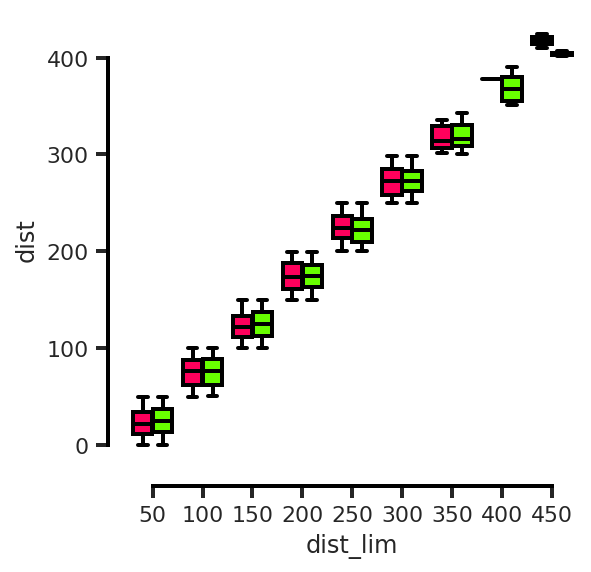

In [26]:
plot_dist_box(hepa_dist_pd_dict,None)


In [53]:
def get_fibro_stat_step(a_use,start_dist,k_split,end_dist,c_hep_normal='5',c_hep_87='6'):
    # a_use = a_concat_6
#     c_hep_normal='4'
#     c_hep_87='6'
    # c_hep_87_ = '5'
    # c_hep_87='3'
    cur_exp_name='final_cls'

    hepa_dist_pd_dict = {
        'dist':[],
        'dist_lim':[],
        'hepa_type':[]
    }


    a_hep_normal = a_use[a_use.obs[cur_exp_name]==c_hep_normal]
    a_hep_normal = a_hep_normal[a_hep_normal.obs['fibro_dist_mum']>0]
    # a_hep_87 = a[a.obs[cur_exp_name]==c_hep_87]
    a_hep_87 = a_use[a_use.obs[cur_exp_name].isin([c_hep_87])]
    a_hep_87 = a_hep_87[a_hep_87.obs['fibro_dist_mum']>0]


    a_hep_all = a_use[a_use.obs[cur_exp_name].isin([c_hep_87,c_hep_normal])]
    a_hep_all = a_hep_all[a_hep_all.obs['fibro_dist_mum']>0]

    thre_list = []
    count_normal_list = []
    count_normal_standard_list = []
    count_87_list = []
    count_87_standard_list = []
    count_ratio_list = []
    count_ratio_standard_list =[]
    dist_pvalue_list = []
    dist_pvalue_list2 = []
    dist_87_list = []
    dist_normal_list = []
    dist_all_list = []
    dist_ratio_list = []

    a_hep_87_num = a_hep_87.shape[0]
    a_hep_normal_num = a_hep_normal.shape[0]
    
    # start_dist = 10
    # k_split = 8
    thre_range = range(start_dist,end_dist,k_split)
    
#     if k_split>=0:
        
#         thre_range = range(start_dist,end_dist,100)
#     else:
#         thre_range = range(start_dist,end_dist,1)
    # thre_range = [100,200,250,300,350,400,450]
    # thre_range = [100,200,300,400,500]
    prev_i = 0
    for i in thre_range:
        if i%100==0:
            print(i)
        cur_a_all = a_hep_all[a_hep_all.obs['fibro_dist_mum']<i] 
        cur_a_all = cur_a_all[cur_a_all.obs['fibro_dist_mum']>prev_i]
        
        cur_a_87 = a_hep_87[a_hep_87.obs['fibro_dist_mum']<i] 
        cur_a_87 = cur_a_87[cur_a_87.obs['fibro_dist_mum']>prev_i]
        
        cur_a_normal = a_hep_normal[a_hep_normal.obs['fibro_dist_mum']<i]  
        cur_a_normal = cur_a_normal[cur_a_normal.obs['fibro_dist_mum']>prev_i]


        cur_dist_87 = cur_a_87.obs['fibro_dist_mum']
        cur_dist_all = cur_a_all.obs['fibro_dist_mum']
        cur_dist_normal = cur_a_normal.obs['fibro_dist_mum']

        dist_87_list.append(np.mean(cur_dist_87))
        dist_normal_list.append(np.mean(cur_dist_normal))
        dist_all_list.append(np.mean(cur_dist_all))
        dist_ratio_list.append(np.mean(np.mean(cur_dist_normal)/np.mean(cur_dist_87)))



    #     cur_dist_87_resample = np.random.choice(cur_dist_87, a_hep_87_num)
    #     cur_dist_normal_resample = np.random.choice(cur_dist_normal, a_hep_normal_num)



        _,pvalue = scipy.stats.ranksums(cur_dist_87,cur_dist_normal)
        _,pvalue2 = scipy.stats.ttest_ind(cur_dist_87,cur_dist_normal)

        dist_pvalue_list.append((pvalue,pvalue2))
#         dist_pvalue_list2.append(pvalue2)

#         count_normal = np.sum(a_hep_normal.obs['fibro_dist_mum']<i)
        count_normal = cur_a_normal.shape[0]
        count_normal_standard = count_normal/a_hep_normal.shape[0]
#         count_87 = np.sum(a_hep_87.obs['fibro_dist_mum']<i)
        count_87 = cur_a_87.shape[0]
        count_87_standard = count_87/a_hep_87.shape[0]

        count_87_ratio = count_87/(count_87+count_normal)
        
        thre_list.append(i)
        count_normal_list.append(count_normal)
        count_87_list.append(count_87)
        count_ratio_list.append(count_87/count_normal)

        count_normal_standard_list.append(count_normal_standard)
        count_87_standard_list.append(count_87_standard)
        count_ratio_standard_list.append(count_87_standard/count_normal_standard)
#         count_ratio_standard_list.append(count_87_ratio)

        cur_dist_list = list(cur_dist_87)
        cur_dist_list.extend(list(cur_dist_normal))
        cur_hepatype_list = ['69+']*cur_dist_87.shape[0]
        cur_hepatype_list.extend(['69-']*cur_dist_normal.shape[0])
        cur_distlim_list = [i]*len(cur_hepatype_list)
        hepa_dist_pd_dict['dist'].extend(cur_dist_list)
        hepa_dist_pd_dict['dist_lim'].extend(cur_distlim_list)
        hepa_dist_pd_dict['hepa_type'].extend(cur_hepatype_list)
        prev_i = i
    return thre_list,dist_ratio_list,dist_pvalue_list,hepa_dist_pd_dict,count_ratio_standard_list
    # deletes



In [12]:
a_concat

AnnData object with n_obs × n_vars = 7070 × 0 
    obs: 'batch', 'cls_3', 'cls_4', 'cls_5', 'cls_5_pca', 'cls_5_pca_reorder', 'cls_5_pca_reorder_IMlast', 'cls_5_reorder', 'cls_6', 'cls_6_bak', 'cls_6_bak_reorder', 'cls_7', 'cls_8_pca', 'exclude_dist', 'fibro_dist', 'fibro_dist_mum', 'final_cls', 'leiden', 'spatial_x', 'spatial_y', 'test', 'test_reorder'
    obsm: 'X_umap', 'spatial'

100
200
300
400
100
200
300
400
500


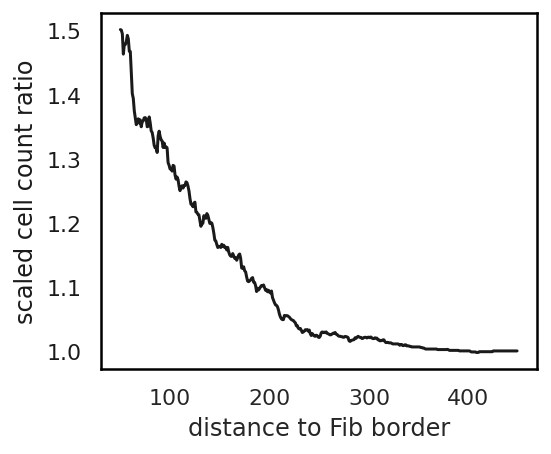

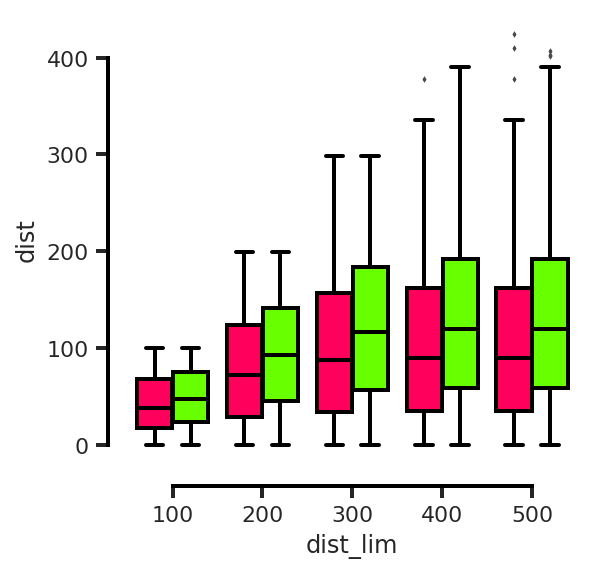

In [27]:
cur_save = 'figures/Supp/count_ratio.png'

thre_list,dist_ratio_list,_,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(a_concat,50,1,450)
plot_count_ratio(count_ratio_standard_list,thre_list,cur_save)
cur_save = 'figures/Supp/dist_box.png'

thre_list,dist_ratio_list,dist_p_list,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(a_concat,100,100,600)
plot_dist_box(hepa_dist_pd_dict,cur_save)


In [26]:
dist_p_list

[(0.0017439178988870863, 0.0021647733183595107),
 (3.859013613090204e-07, 6.646496869912673e-07),
 (9.577490936805088e-09, 1.1667979050380522e-07),
 (2.2074571777727804e-10, 1.0962224924822874e-09),
 (2.520392189277598e-10, 1.8857091272202274e-09)]

## joint hepa fib dist

In [2]:
rep0_dump = 'fig4_rep0_cls6_reorder_full.h5ad'
rep1_dump = 'fig4_rep1_cls6_full_adddist.h5ad'
rep2_dump = 'fig4_rep2_cls6_reorder_full.h5ad'
rep3_dump = 'fig4_rep3_cls6_reorder_full.h5ad'

rep0_dump_side2 = 'fig4_rep0_cls6_reorder_full_side2.h5ad'
rep2_dump_side2 = 'fig4_rep2_cls6_reorder_full_side2.h5ad'

P1_dump = '/home/yzy/ipynbs/figures/Supp/P1/data.h5ad'

a_rep0 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep0_dump)[:,0]
a_rep1 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep1_dump)[:,0]
a_rep2 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep2_dump)[:,0]
a_rep3 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep3_dump)[:,0]
a_rep0_side2 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep0_dump_side2)[:,0]
a_rep2_side2 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep2_dump_side2)[:,0]

a_P1 = ad.read_h5ad(P1_dump)[:,0]

# a_rep0 = a_rep0[:,0]

 

In [10]:
a_rep0.obs['final_cls'] = a_rep0.obs['cls_5_reorder']
a_rep1.obs['final_cls'] = a_rep1.obs['cls_5_pca_reorder']
a_rep2.obs['final_cls'] = a_rep2.obs['cls_5_reorder']

# rep3的4是normal，6是87
rep3_cls = np.array(a_rep3.obs['cls_6_bak_reorder'].copy())
rep3_cls_tmp = rep3_cls.copy()
rep3_cls[rep3_cls_tmp=='4']='5'
rep3_cls[rep3_cls_tmp=='5']='4'


a_rep3.obs['final_cls'] = rep3_cls
a_rep3.obs['final_cls'] = a_rep3.obs['final_cls'].astype('category')

a_rep0_side2.obs['final_cls'] = a_rep0_side2.obs['cls_5_reorder']
a_rep2_side2.obs['final_cls'] = a_rep2_side2.obs['cls_5_reorder']



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [10]:
np.unique(a_rep3.obs['cls_6_bak_reorder'],return_counts=1)

(array(['1', '2', '3', '4', '5', '6'], dtype=object),
 array([ 84,  74,  85,  94, 143,  66]))

In [122]:
np.unique(a_rep3.obs['final_cls'],return_counts=1)

(array(['1', '2', '3', '4', '5', '6'], dtype=object),
 array([ 84,  74,  85, 143,  94,  66]))

In [45]:
a_rep1 = a.copy()

In [11]:
a_concat_6 = a_rep0.concatenate([a_rep1,a_rep2,a_rep3,a_rep0_side2,a_rep2_side2])
a_concat_4 = a_rep0.concatenate([a_rep1,a_rep2,a_rep3])

In [12]:
np.unique(a_concat.obs['final_cls'])

array(['1', '2', '3', '4', '5', '6'], dtype=object)

In [14]:
a_rep3

AnnData object with n_obs × n_vars = 546 × 1 
    obs: 'cls_6', 'cls_6_bak', 'cls_6_bak_reorder', 'fibro_dist', 'fibro_dist_mum', 'final_cls'
    uns: 'cls_6_bak_colors', 'cls_6_bak_reorder_colors', 'dendrogram_cls_6', 'dendrogram_cls_6_bak', 'rank_genes_groups', 'rep_list'
    obsm: 'X_pca', 'X_umap', 'cls_6_bak_rep', 'cls_6_rep', 'spatial'

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

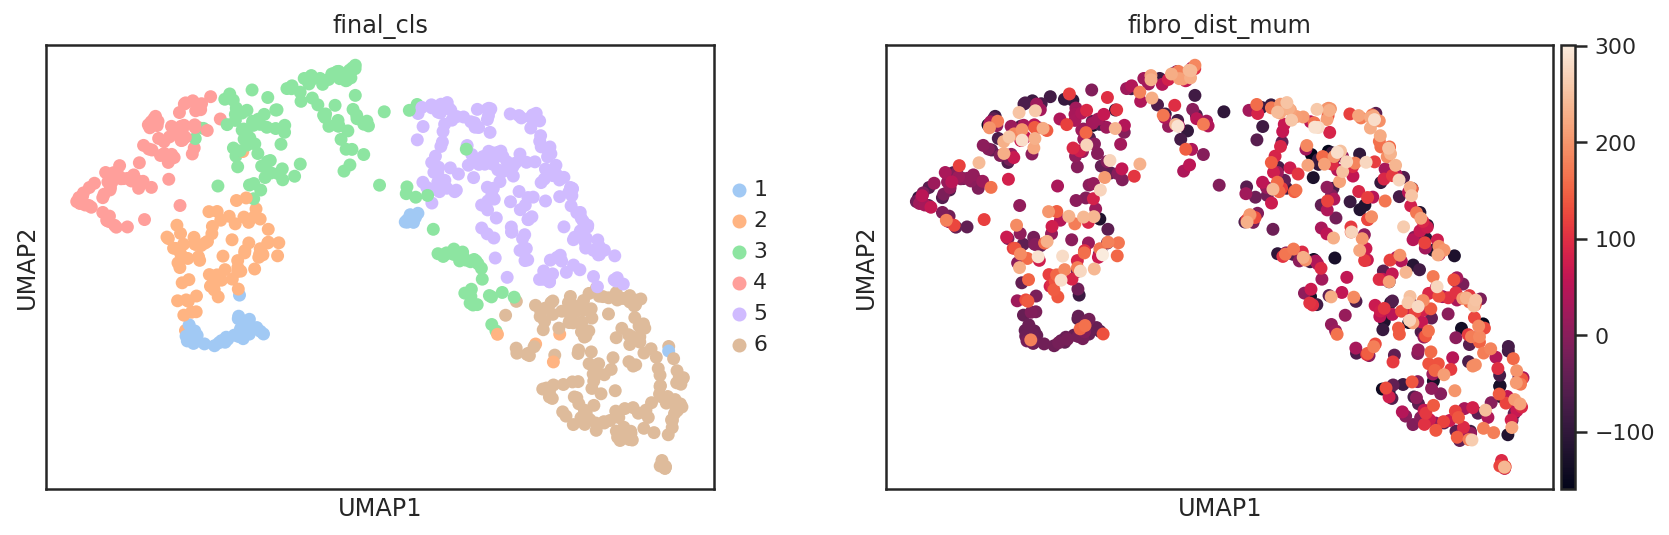

In [116]:
sc.pl.umap(a_rep0,color=['final_cls','fibro_dist_mum'])

In [73]:
cur_dist_87_resample.shape

(475,)

In [157]:
count_ratio_standard_list

[1.167719298245614,
 1.1201958384332926,
 1.1374711477488904,
 1.1010284331518452,
 1.010631087828436,
 1.0151482153660012,
 1.0061225386135715,
 0.9978947368421053,
 1.0]

In [17]:
def get_fibro_stat(a_use,start_dist,k_split):
    # a_use = a_concat_6
    c_hep_normal='5'
    c_hep_87='6'
    # c_hep_87_ = '5'
    # c_hep_87='3'
    cur_exp_name='final_cls'

    hepa_dist_pd_dict = {
        'dist':[],
        'dist_lim':[],
        'hepa_type':[]
    }


    a_hep_normal = a_use[a_use.obs[cur_exp_name]==c_hep_normal]
    a_hep_normal = a_hep_normal[a_hep_normal.obs['fibro_dist_mum']>0]
    # a_hep_87 = a[a.obs[cur_exp_name]==c_hep_87]
    a_hep_87 = a_use[a_use.obs[cur_exp_name].isin([c_hep_87])]
    a_hep_87 = a_hep_87[a_hep_87.obs['fibro_dist_mum']>0]


    a_hep_all = a_use[a_use.obs[cur_exp_name].isin([c_hep_87,c_hep_normal])]
    a_hep_all = a_hep_all[a_hep_all.obs['fibro_dist_mum']>0]

    thre_list = []
    count_normal_list = []
    count_normal_standard_list = []
    count_87_list = []
    count_87_standard_list = []
    count_ratio_list = []
    count_ratio_standard_list =[]
    dist_pvalue_list = []
    dist_pvalue_list2 = []
    dist_87_list = []
    dist_normal_list = []
    dist_all_list = []
    dist_ratio_list = []

    a_hep_87_num = a_hep_87.shape[0]
    a_hep_normal_num = a_hep_normal.shape[0]
    prev_i = 0
    # start_dist = 10
    # k_split = 8
    if k_split>=0:
        
        thre_range = range(start_dist,450,int(400/k_split))
    else:
        thre_range = range(start_dist,450,1)
    # thre_range = [100,200,250,300,350,400,450]
    # thre_range = [100,200,300,400,500]

    for i in thre_range:
        if i%100==0:
            print(i)
        cur_a_all = a_hep_all[a_hep_all.obs['fibro_dist_mum']<i]
        cur_a_87 = a_hep_87[a_hep_87.obs['fibro_dist_mum']<i]
        cur_a_normal = a_hep_normal[a_hep_normal.obs['fibro_dist_mum']<i]



        cur_dist_87 = cur_a_87.obs['fibro_dist_mum']
        cur_dist_all = cur_a_all.obs['fibro_dist_mum']
        cur_dist_normal = cur_a_normal.obs['fibro_dist_mum']

        dist_87_list.append(np.mean(cur_dist_87))
        dist_normal_list.append(np.mean(cur_dist_normal))
        dist_all_list.append(np.mean(cur_dist_all))
        dist_ratio_list.append(np.mean(np.mean(cur_dist_normal)/np.mean(cur_dist_87)))



    #     cur_dist_87_resample = np.random.choice(cur_dist_87, a_hep_87_num)
    #     cur_dist_normal_resample = np.random.choice(cur_dist_normal, a_hep_normal_num)



        _,pvalue = scipy.stats.ranksums(cur_dist_87,cur_dist_normal)
        _,pvalue2 = scipy.stats.ttest_ind(cur_dist_87,cur_dist_normal)

        dist_pvalue_list.append(pvalue)
        dist_pvalue_list2.append(pvalue2)

        count_normal = np.sum(a_hep_normal.obs['fibro_dist_mum']<i)
        count_normal_standard = count_normal/a_hep_normal.shape[0]
        count_87 = np.sum(a_hep_87.obs['fibro_dist_mum']<i)
        count_87_standard = count_87/a_hep_87.shape[0]

        thre_list.append(i)
        count_normal_list.append(count_normal)
        count_87_list.append(count_87)
        count_ratio_list.append(count_87/count_normal)

        count_normal_standard_list.append(count_normal_standard)
        count_87_standard_list.append(count_87_standard)
        count_ratio_standard_list.append(count_87_standard/count_normal_standard)


        cur_dist_list = list(cur_dist_87)
        cur_dist_list.extend(list(cur_dist_normal))
        cur_hepatype_list = ['69+']*cur_dist_87.shape[0]
        cur_hepatype_list.extend(['69-']*cur_dist_normal.shape[0])
        cur_distlim_list = [i]*len(cur_hepatype_list)
        hepa_dist_pd_dict['dist'].extend(cur_dist_list)
        hepa_dist_pd_dict['dist_lim'].extend(cur_distlim_list)
        hepa_dist_pd_dict['hepa_type'].extend(cur_hepatype_list)
        prev_i = i
    return thre_list,dist_ratio_list,dist_pvalue_list,hepa_dist_pd_dict,count_ratio_standard_list
    # deletes



The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


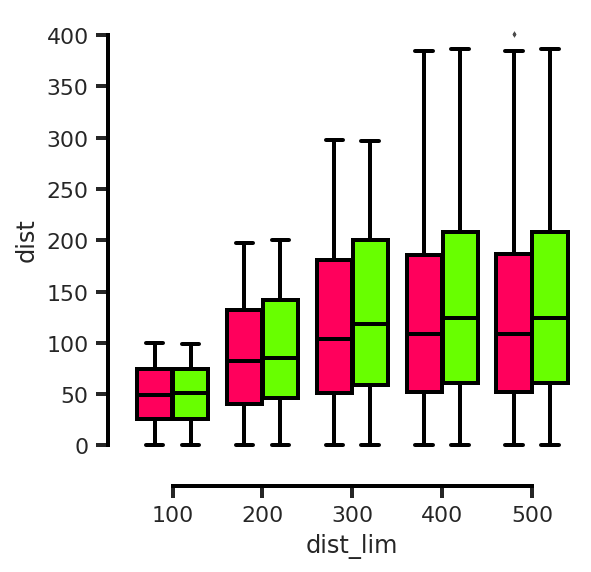

In [36]:
# sns.set(context='paper', style='dark', palette='flag', 
#         font='arial', font_scale=1, color_codes=True, rc=None)
# sns.set_style('ticks', {'axes.edgecolor': 'k',  
#                         'xtick.color': 'k',
#                         'ytick.color': 'k'})
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.sze": 8})

hepa_dist_pd_df = pd.DataFrame(hepa_dist_pd_dict)

import seaborn as sns
sns.set(style="ticks", palette="pastel")

save = 'figures/fibro_dist_box3.png'
# Load the example tips dataset
# tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
fig,ax = plt.subplots(1,1,figsize=(4,4))
g = sns.boxplot(x="dist_lim", y="dist",
            hue="hepa_type", palette=["#FF005C", "#68FF00"],saturation=1,fliersize=1,linewidth=2,
            data=hepa_dist_pd_df,ax=ax)
sns.despine(offset=10, trim=True)
ax.get_legend().remove()

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
#     box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

# plt.savefig(save,transparent=True,format='png',bbox_inches='tight',dpi=500)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
# ax.spines["left"].set_facecolor("red")
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# ax.tick_params(axis='y', labelcolor='red')
# ax.tick_params(axis='x', labelcolor=color)
# plt.setp(ax.lines, color='blue')
# plt.savefig(save,transparent=True,format='png',bbox_inches='tight',dpi=500)


In [18]:
a_use_list = [a_rep0,a_rep1,a_rep2,a_rep3,a_rep0_side2,a_rep2_side2]
thre_list,dist_ratio_list,_,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(a_use_list[0],30,-1)


100
200
300
400


In [21]:
def plot_count_ratio(count_ratio_standard_list,thre_list,save):
    sns.set_style('white')
    save_tmp = 'figures/fibro_dist_line_{0}.png'

    t=thre_list
    data1 = count_ratio_standard_list
    # data2 = -np.log10(dist_pvalue_list2)
    fig, ax1 = plt.subplots(1,1,figsize=(6/1.5,5/1.5))

    color = 'k'
    ax1.set_xlabel('distance to Fib border')
    ax1.set_ylabel('scaled cell count ratio', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    # color = 'tab:blue'
    # ax2.set_ylabel('P value (-log10)', color=color)  # we already handled the x-label with ax1
    # ax2.plot(t, data2, color=color)
    # ax2.tick_params(axis='y', labelcolor=color)
    ax1.spines["bottom"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1.spines["top"].set_color("black")
    ax1.spines['right'].set_color("black")
    # ax.spines["left"].set_facecolor("red")
    # ax1.spines["left"].set_linewidth(2)
    # ax1.spines["bottom"].set_linewidth(2)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    # plt.show()
    if save:
        
        plt.savefig(save_tmp.format(save),transparent=True,format='png',bbox_inches='tight',dpi=500)
    # plt.savefig(transparent=True,format='png',bbox_inches='tight',dpi=500)


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


100
200
300
400
100
200
300
400
100
200
300
400
100
200
300
400
100
200
300
400
100
200
300
400


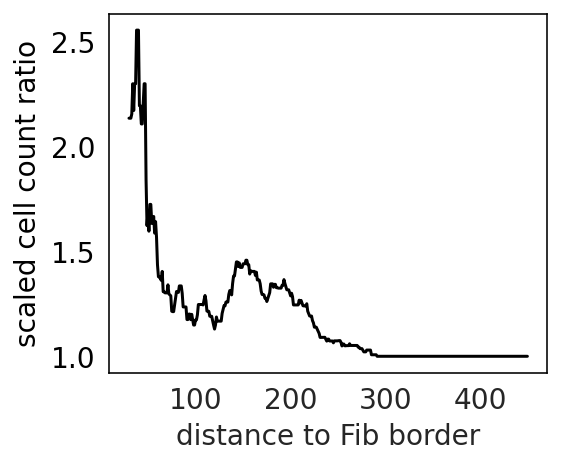

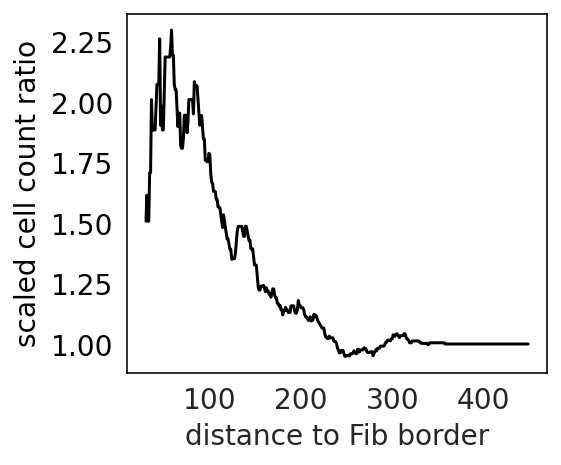

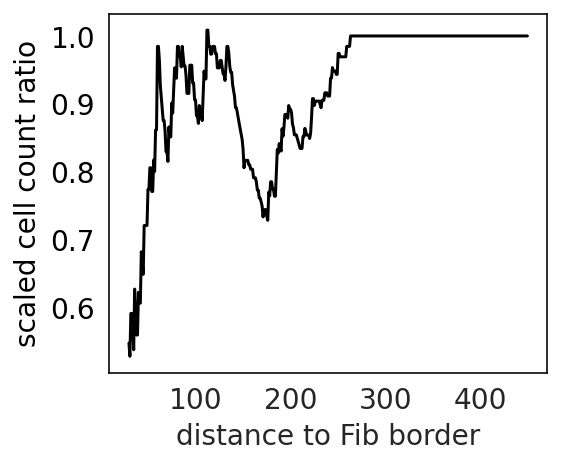

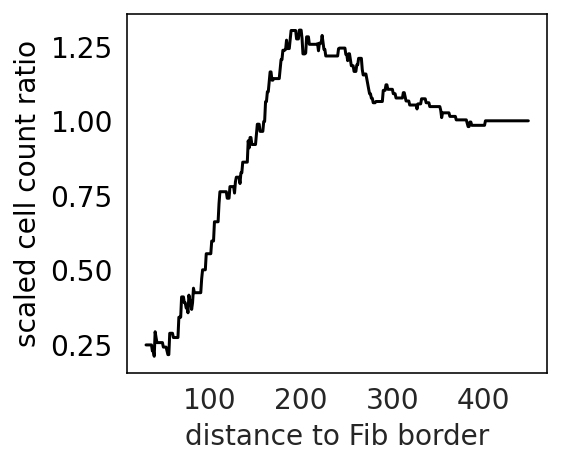

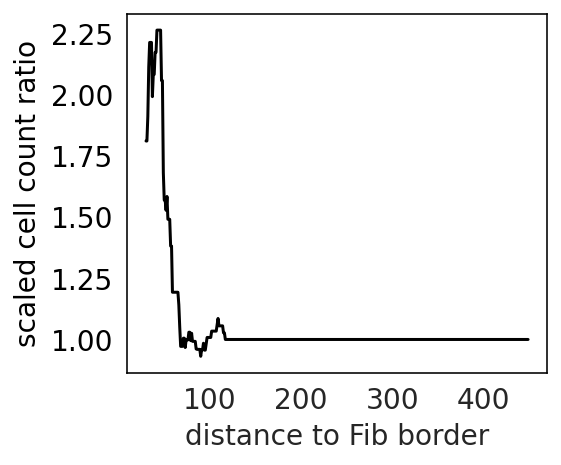

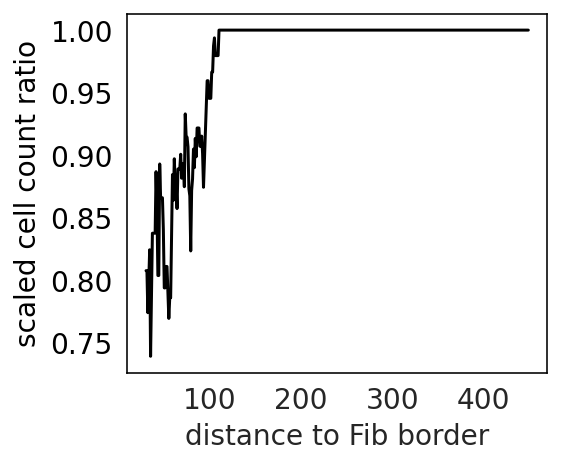

In [22]:
a_use_list = [a_rep0,a_rep1,a_rep2,a_rep3,a_rep0_side2,a_rep2_side2]
save_list = ['a_rep0','a_rep1','a_rep2','a_rep3','a_rep0_side2','a_rep2_side2']
for i in range(len(a_use_list)):
    a_use = a_use_list[i]
    save = save_list[i]
    thre_list,dist_ratio_list,_,hepa_dist_pd_dict,count_ratio_standard_list = get_fibro_stat(a_use,30,-1)
    plot_count_ratio(count_ratio_standard_list,thre_list,save)


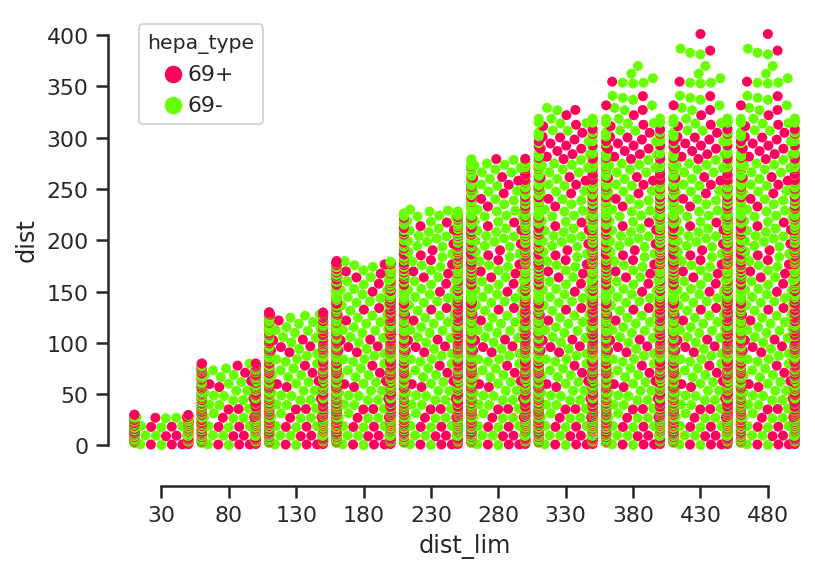

In [106]:
hepa_dist_pd_df = pd.DataFrame(hepa_dist_pd_dict)

import seaborn as sns
sns.set(style="ticks", palette="pastel")

# Load the example tips dataset
# tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
sns.swarmplot(x="dist_lim", y="dist",
            hue="hepa_type", palette=["#FF005C", "#68FF00"],
            data=hepa_dist_pd_df)
sns.despine(offset=10, trim=True)

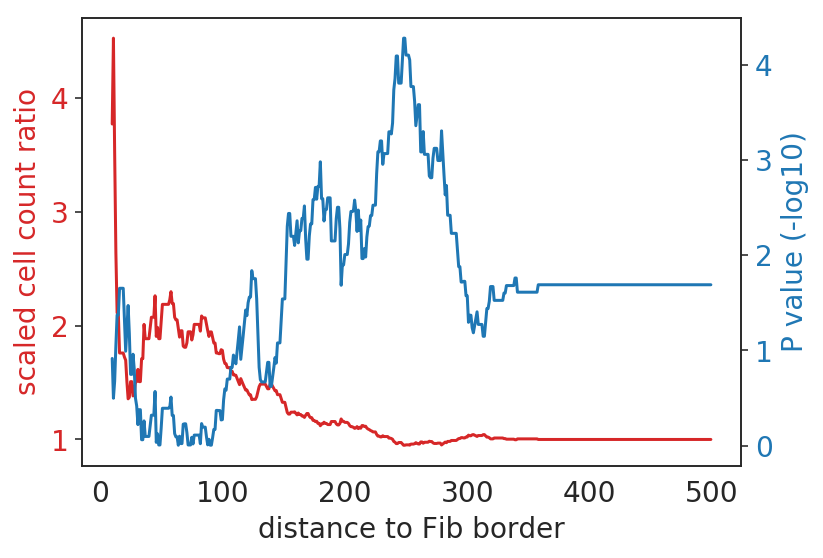

In [71]:
sns.set_style('white')
t=thre_list
data1 = count_ratio_standard_list
data2 = -np.log10(dist_pvalue_list2)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('distance to Fib border')
ax1.set_ylabel('scaled cell count ratio', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('P value (-log10)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [359]:
a_rep0 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep0_dump)


In [361]:
a_rep0

AnnData object with n_obs × n_vars = 716 × 231 
    obs: 'cls_5', 'cls_5_pca', 'cls_8_pca', 'cls_4', 'leiden', 'cls_5_reorder', 'fibro_dist', 'fibro_dist_mum'
    uns: 'cls_4_colors', 'cls_5_colors', 'cls_5_pca_colors', 'cls_5_reorder_colors', 'cls_8_pca_colors', 'leiden', 'leiden_colors', 'neighbors', 'rep_list', 'umap'
    obsm: 'X_umap', 'cls_4_rep', 'cls_5_pca_rep', 'cls_5_rep', 'cls_8_pca_rep', 'spatial'

In [366]:
import scanpy as sc

In [370]:
sc.__version__

'1.4.5.1'

In [367]:
sc.tl.rank_genes_groups(a_rep0,groupby='cls_8_pca')

ranking genes
    finished (0:00:00)


# save anndata

In [17]:
a

AnnData object with n_obs × n_vars = 902 × 228 
    obs: 'cls_5', 'cls_5_pca', 'cls_5_pca_reorder'
    uns: 'cls_5_colors', 'cls_5_pca_colors', 'cls_5_pca_reorder_colors', 'dendrogram_cls_5_pca', 'dendrogram_cls_5_pca_reorder', 'rank_genes_groups', 'rep_list'
    obsm: 'X_pca', 'X_umap', 'cls_5_pca_rep', 'cls_5_rep'

In [140]:
a.write('figures/Fig2/c4/fig2_c4.h5py')

In [309]:
a_rep1_heatmap.write('figures/Fig4_dump_data/fig4_rep1_cls6_fluo.h5ad')

In [284]:
a.write('figures/Fig4_dump_data/fig4_rep1_cls5_reorder_full.h5ad')

In [226]:
a_test = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/fig4_csub.h5ad')


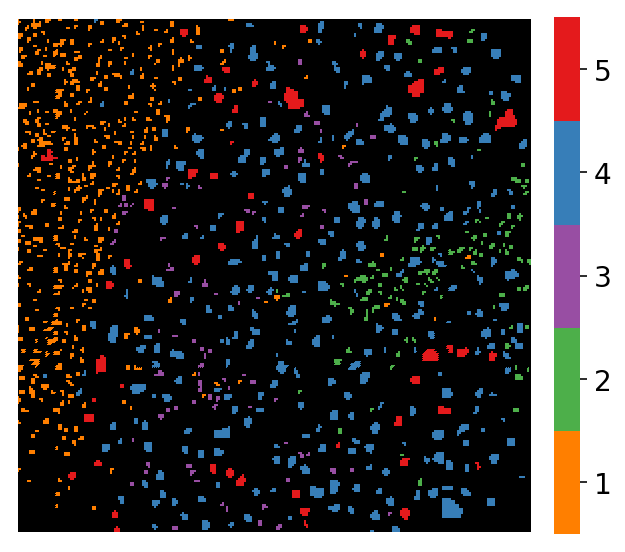

In [227]:
plot_label_image(a_test.obs['cls_sub'],a_test.uns['cls_sub_colors'],mask=[0,1,2,3,4])


In [229]:
1+1

2